# AI Usage and Source
- The code is partly generated by GPT-4o with user input, review, and redact

In [129]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
np.random.seed(42)
import arviz as az
import pymc as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import joblib

# Mid-Semester

## Primary Dataset

### Import (Primary Dataset)

In [2]:
df_carrier = []

files = [
    '2014_T_T100D_SEGMENT_ALL_CARRIER.csv', '2015_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2016_T_T100D_SEGMENT_ALL_CARRIER.csv', '2017_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2018_T_T100D_SEGMENT_ALL_CARRIER.csv', '2019_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2020_T_T100D_SEGMENT_ALL_CARRIER.csv', '2021_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2022_T_T100D_SEGMENT_ALL_CARRIER.csv', '2023_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2024_T_T100D_SEGMENT_ALL_CARRIER.csv'
]

folder_path = 'DATA'

df_carrier = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in files], ignore_index=True)
# df_carrier.replace(0, np.nan, inplace=True)

df_carrier.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Georgia,ATL,Georgia,456,1,2014,1,3,1,F
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Florida,FLL,Florida,456,1,2014,1,3,1,F
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Florida,GNV,Florida,456,1,2014,1,3,1,F
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,Colorado,DEN,Colorado,698,1,2014,2,5,1,F
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,California,SAN,California,698,1,2014,1,1,1,F


### Validation (Primary Dataset)

In [3]:
# Validation

# Count the number of rows where DEPARTURES_PERFORMED is 0 and AIR_TIME > 0
INVALID_DEPARTURE_PERFORMED = ((df_carrier['DEPARTURES_PERFORMED'] == 0) & (df_carrier['AIR_TIME'] > 0)).sum()
print(f"Number of invalid DEPARTURES_PERFORMED: {INVALID_DEPARTURE_PERFORMED}")

# If DEPARTURES_PERFORMED is 0 and AIR_TIME > 0, set DEPARTURES_PERFORMED to 1
df_carrier.loc[(df_carrier['DEPARTURES_PERFORMED'] == 0) & (df_carrier['AIR_TIME'] > 0), 'DEPARTURES_PERFORMED'] = 1

# Else if DEPARTURES_PERFORMED is 0 then remove the rows as there is no AIR_TIME.
df_carrier = df_carrier[~((df_carrier['DEPARTURES_PERFORMED'] == 0) & (df_carrier['AIR_TIME'] == 0))]

# If DISTANCE > 0 and AIR_TIME = 0 then AIR_TIME is missing
df_carrier.loc[(df_carrier['DISTANCE'] > 0) & (df_carrier['AIR_TIME'] == 0), 'AIR_TIME'] = np.nan

# If DISTANCE > 0 and RAMP_TO_RAMP = 0 then RAMP_TO_RAMP is missing
df_carrier.loc[(df_carrier['DISTANCE'] > 0) & (df_carrier['RAMP_TO_RAMP'] == 0), 'RAMP_TO_RAMP'] = np.nan

# Calculate GROUND_TIME as the difference between RAMP_TO_RAMP and AIR_TIME
df_carrier['GROUND_TIME'] = df_carrier['RAMP_TO_RAMP'] - df_carrier['AIR_TIME']

# Count the number of rows where RAMP_TO_RAMP is less than AIR_TIME
INVALID_AIR_TIME = (df_carrier['RAMP_TO_RAMP'] < df_carrier['AIR_TIME']).sum()
print(f"Number of invalid AIR_TIME: {INVALID_AIR_TIME}")



Number of invalid DEPARTURES_PERFORMED: 648
Number of invalid AIR_TIME: 0


### Imputation (Primary Dataset)

In [4]:
# Step 1: Split the data into two parts: one with missing AIR_TIME and one without
df_missing_air_time = df_carrier[df_carrier['AIR_TIME'].isnull()]
df_complete = df_carrier[df_carrier['AIR_TIME'].notnull()]

# Step 2: Train a linear regression model using the complete data
X_train = df_complete[['DISTANCE']]  # Predictor: DISTANCE
y_train = df_complete['AIR_TIME']    # Target: AIR_TIME

# Initialize the regression model
reg_model = LinearRegression()

# Train the model
reg_model.fit(X_train, y_train)

# Step 3: Predict the missing AIR_TIME values using the trained model
X_missing = df_missing_air_time[['DISTANCE']]  # Use the DISTANCE values where AIR_TIME is missing
df_missing_air_time.loc[:, 'AIR_TIME'] = reg_model.predict(X_missing)

# Step 4: Impute the missing values in the original DataFrame
df_carrier.loc[df_carrier['AIR_TIME'].isnull(), 'AIR_TIME'] = df_missing_air_time['AIR_TIME']

In [5]:
# Step 1: Split the data into two parts: one with missing RAMP_TO_RAMP and one without
df_missing_ramp = df_carrier[df_carrier['RAMP_TO_RAMP'].isnull()]
df_complete = df_carrier[df_carrier['RAMP_TO_RAMP'].notnull()]

# Step 2: Train a linear regression model using the complete data
X_train = df_complete[['PASSENGERS', 'FREIGHT']]  # Predictors: PASSENGERS and FREIGHT
y_train = df_complete['RAMP_TO_RAMP']             # Target: RAMP_TO_RAMP

# Initialize the regression model
reg_model = LinearRegression()

# Train the model
reg_model.fit(X_train, y_train)

# Step 3: Predict the missing RAMP_TO_RAMP values using the trained model
X_missing = df_missing_ramp[['PASSENGERS', 'FREIGHT']]  # Use PASSENGERS and FREIGHT for missing RAMP_TO_RAMP
df_missing_ramp.loc[:, 'RAMP_TO_RAMP'] = reg_model.predict(X_missing)

# Step 4: Impute the missing values in the original DataFrame
df_carrier.loc[df_carrier['RAMP_TO_RAMP'].isnull(), 'RAMP_TO_RAMP'] = df_missing_ramp['RAMP_TO_RAMP']

In [6]:
# # Check if GROUND_TIME has missing values (NaN)
# missing_data = df_carrier['GROUND_TIME'].isnull()

# # Display rows where GROUND_TIME is missing
# df_missing_ground_time = df_carrier[missing_data]

# # Show the missing data
# df_missing_ground_time.head()

df_carrier['GROUND_TIME'] = df_carrier['RAMP_TO_RAMP'] - df_carrier['AIR_TIME']

## Secondary Dataset

In [7]:
# Import L_* dataset (dictionary dataset)
folder_path = 'TABLES'
tab_aircraft_config = pd.read_csv(os.path.join(folder_path, 'L_AIRCRAFT_CONFIG.csv'))
tab_aircraft_type = pd.read_csv(os.path.join(folder_path, 'L_AIRCRAFT_TYPE.csv'))
tab_airport_id = pd.read_csv(os.path.join(folder_path, 'L_AIRPORT_ID.csv'))
tab_airport = pd.read_csv(os.path.join(folder_path, 'L_AIRPORT.csv'))
tab_distance_group = pd.read_csv(os.path.join(folder_path, 'L_DISTANCE_GROUP_500.csv'))
tab_service_class = pd.read_csv(os.path.join(folder_path, 'L_SERVICE_CLASS.csv'))
tab_unique_carriers = pd.read_csv(os.path.join(folder_path, 'L_UNIQUE_CARRIERS.csv'))


## Third Dataset

In [8]:
# Import df_aiport (predictor dataset)

df_airport = []
folder_path = 'DATA'
df_airport = pd.read_csv(os.path.join(folder_path, 'airports.csv'))

df_airport.head()


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [9]:
# Filter data with IATA only and US only
df_filtered = df_airport[(df_airport['iata_code'].notna()) & (df_airport['iso_country'] == 'US')]

# Create a lookup table for predictor
airport_tab_fac = df_filtered[['iata_code', 'latitude_deg', 'longitude_deg', 'elevation_ft', 'type']]

In [10]:
# Merge df_carrier with all columns from airport_tab_fac
df_carrier = df_carrier.merge(airport_tab_fac, 
                              left_on='ORIGIN', 
                              right_on='iata_code', 
                              how='left')

# Drop the 'iata_code' column
df_carrier.drop(columns=['iata_code'], inplace=True)

## Data Exploration

In [11]:
# Filter Michigan only
df_michigan = df_carrier[df_carrier['ORIGIN_STATE_NM'] == 'Michigan']

# Create a pivot table for Michigan
pivot_table_michigan = pd.pivot_table(df_michigan, 
                                      values='DEPARTURES_PERFORMED', 
                                      index='YEAR', 
                                      columns='MONTH', 
                                      aggfunc='sum')

# Display the pivot table
pivot_table_michigan = pivot_table_michigan / 1000

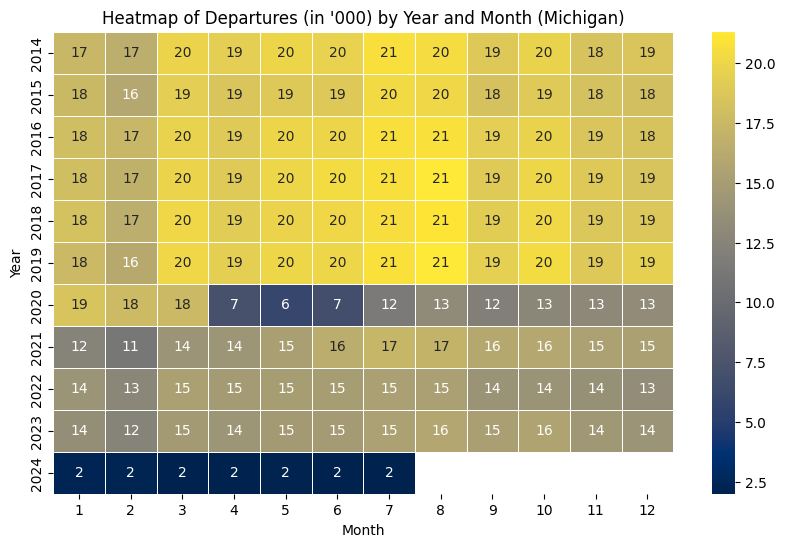

In [12]:
# Create the heatmap
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(pivot_table_michigan, annot=True, fmt=".0f", cmap='cividis', linewidths=.5)

# Add titles and labels
plt.title('Heatmap of Departures (in \'000) by Year and Month (Michigan)')
plt.xlabel('Month')
plt.ylabel('Year')

# Show the heatmap
plt.show()

In [13]:
print(df_carrier.describe())

       DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED       PAYLOAD         SEATS  \
count          3.924284e+06          3.924284e+06  3.924284e+06  3.924284e+06   
mean           2.076107e+01          2.158313e+01  7.297122e+05  2.276113e+03   
std            3.740927e+01          3.540076e+01  1.388445e+06  4.586052e+03   
min            0.000000e+00          1.000000e+00  0.000000e+00  0.000000e+00   
25%            0.000000e+00          1.000000e+00  3.620000e+04  5.000000e+01   
50%            5.000000e+00          7.000000e+00  1.883020e+05  3.620000e+02   
75%            2.800000e+01          2.800000e+01  8.955960e+05  2.700000e+03   
max            2.361000e+03          1.330000e+03  4.953270e+07  1.103360e+05   

         PASSENGERS       FREIGHT          MAIL      DISTANCE  RAMP_TO_RAMP  \
count  3.924284e+06  3.924284e+06  3.924284e+06  3.924284e+06  3.924284e+06   
mean   1.807290e+03  7.338529e+04  2.953501e+03  7.220123e+02  2.702533e+03   
std    3.778110e+03  4.438069e+05

#### Ground Time Analysis

Summary Statistics for GROUND_TIME:
count    3.924284e+06
mean     4.722786e+02
std      1.035546e+03
min     -1.409036e+04
25%      2.500000e+01
50%      1.300000e+02
75%      6.200000e+02
max      8.948300e+05
Name: GROUND_TIME, dtype: float64

Missing values in GROUND_TIME: 0


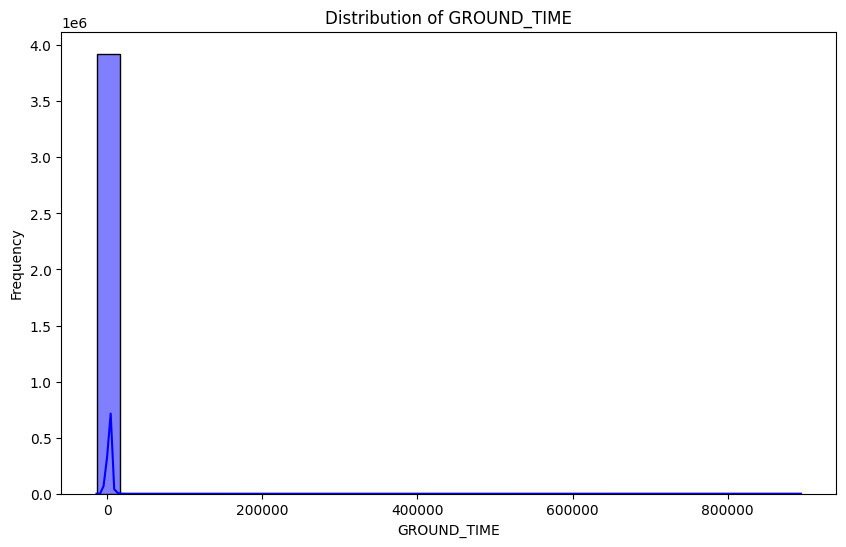

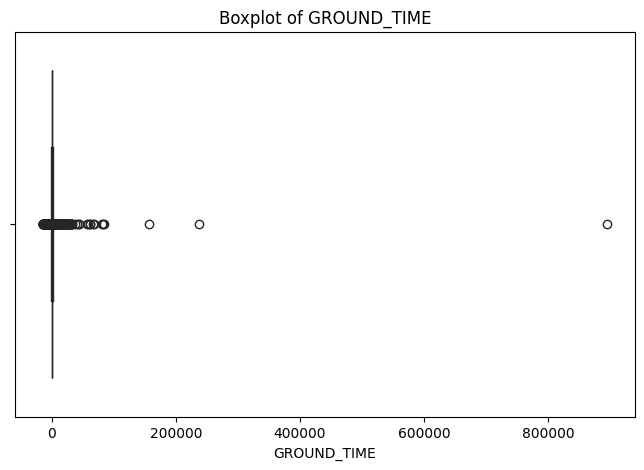

In [14]:
# Step 1: Summary statistics for GROUND_TIME
ground_time_summary = df_carrier['GROUND_TIME'].describe()
print("Summary Statistics for GROUND_TIME:")
print(ground_time_summary)

# Step 2: Check for missing values
missing_ground_time = df_carrier['GROUND_TIME'].isnull().sum()
print(f"\nMissing values in GROUND_TIME: {missing_ground_time}")

# Step 3: Plotting the distribution of GROUND_TIME
plt.figure(figsize=(10, 6))

# Histogram and KDE plot for GROUND_TIME
sns.histplot(df_carrier['GROUND_TIME'], kde=True, bins=30, color='blue')
plt.title('Distribution of GROUND_TIME')
plt.xlabel('GROUND_TIME')
plt.ylabel('Frequency')

plt.show()

# Step 4: Boxplot to detect outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_carrier['GROUND_TIME'], color='green')
plt.title('Boxplot of GROUND_TIME')
plt.xlabel('GROUND_TIME')

plt.show()

In [15]:
# Log transform the GROUND_TIME to reduce skewness
df_carrier['LOG_GROUND_TIME'] = np.log1p(df_carrier['GROUND_TIME'])  # log1p to handle 0 values



c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


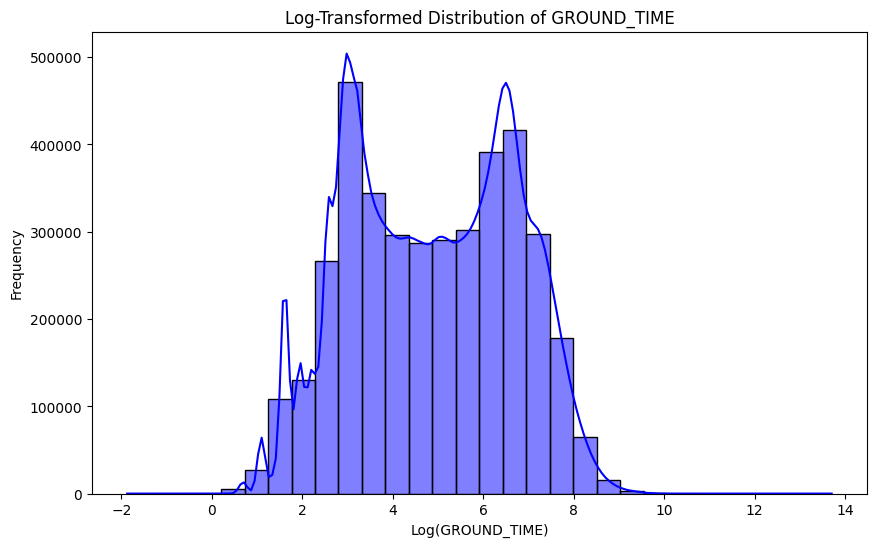

In [16]:
# Plot the log-transformed GROUND_TIME distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_carrier['LOG_GROUND_TIME'], kde=True, bins=30, color='blue')
plt.title('Log-Transformed Distribution of GROUND_TIME')
plt.xlabel('Log(GROUND_TIME)')
plt.ylabel('Frequency')

plt.show()

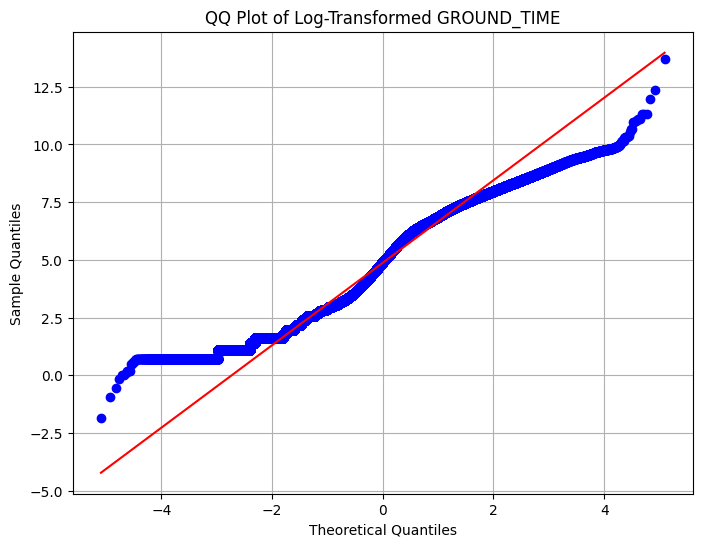

In [17]:
# Ensure there are no NaN values in data
log_ground_time_data = df_carrier['LOG_GROUND_TIME'].dropna()

# Generate the QQ plot with the reference line
plt.figure(figsize=(8, 6))
stats.probplot(log_ground_time_data, dist="norm", plot=plt)
plt.title('QQ Plot of Log-Transformed GROUND_TIME')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)  # Add grid for better readability
plt.show()

In [18]:
# Translate aircraft_config using tab_aircraft_config
tab_aircraft_config.rename(columns={'Description': 'AIRCRAFT_CONFIG_DESC'}, inplace=True)

df_carrier = df_carrier.merge(tab_aircraft_config, 
                              left_on='AIRCRAFT_CONFIG', 
                              right_on='Code', 
                              how='left')

df_carrier.drop(columns=['Code'], inplace=True)

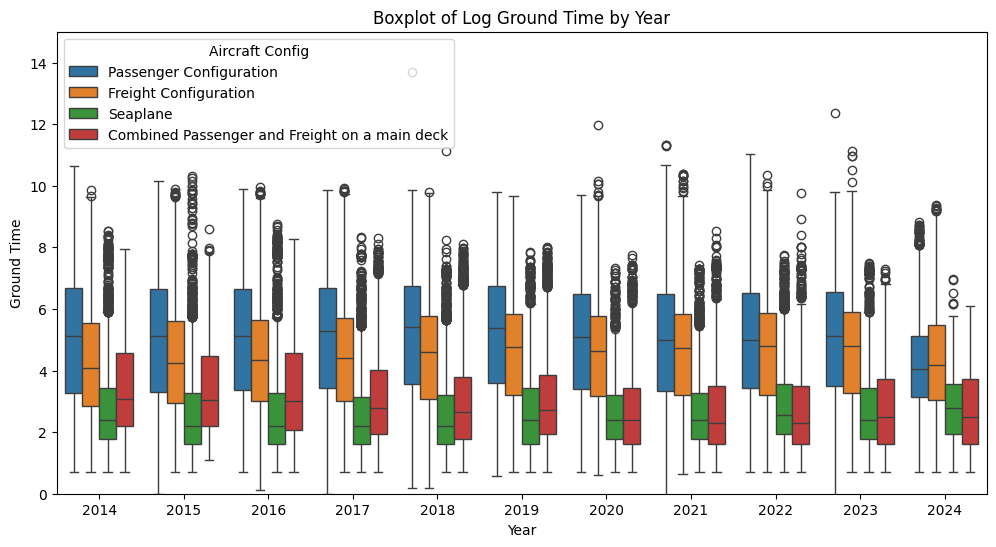

In [19]:
# Create the boxplot for LOG_GROUND_TIME by YEAR, divided by AIRCRAFT_CONFIG
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_carrier, x='YEAR', y='LOG_GROUND_TIME', hue='AIRCRAFT_CONFIG_DESC')
plt.ylim(0, 15)
plt.title('Boxplot of Log Ground Time by Year')
plt.legend(loc='upper left', title='Aircraft Config')
plt.xlabel('Year')
plt.ylabel('Ground Time')
plt.show()

### Correlation Analysis

Correlation Matrix:
                      DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED   PAYLOAD  \
DEPARTURES_SCHEDULED              1.000000              0.951546  0.688506   
DEPARTURES_PERFORMED              0.951546              1.000000  0.729972   
PAYLOAD                           0.688506              0.729972  1.000000   
SEATS                             0.814800              0.839631  0.796214   
PASSENGERS                        0.791503              0.817077  0.788106   
FREIGHT                           0.016048              0.044642  0.498023   
MAIL                              0.067852              0.084518  0.194393   
DISTANCE                          0.005562             -0.003443  0.210563   
RAMP_TO_RAMP                      0.749750              0.780383  0.771885   
AIR_TIME                          0.696771              0.725879  0.749008   
AIRCRAFT_TYPE                     0.096288              0.074677  0.202554   
AIRCRAFT_CONFIG                  -0.145819  

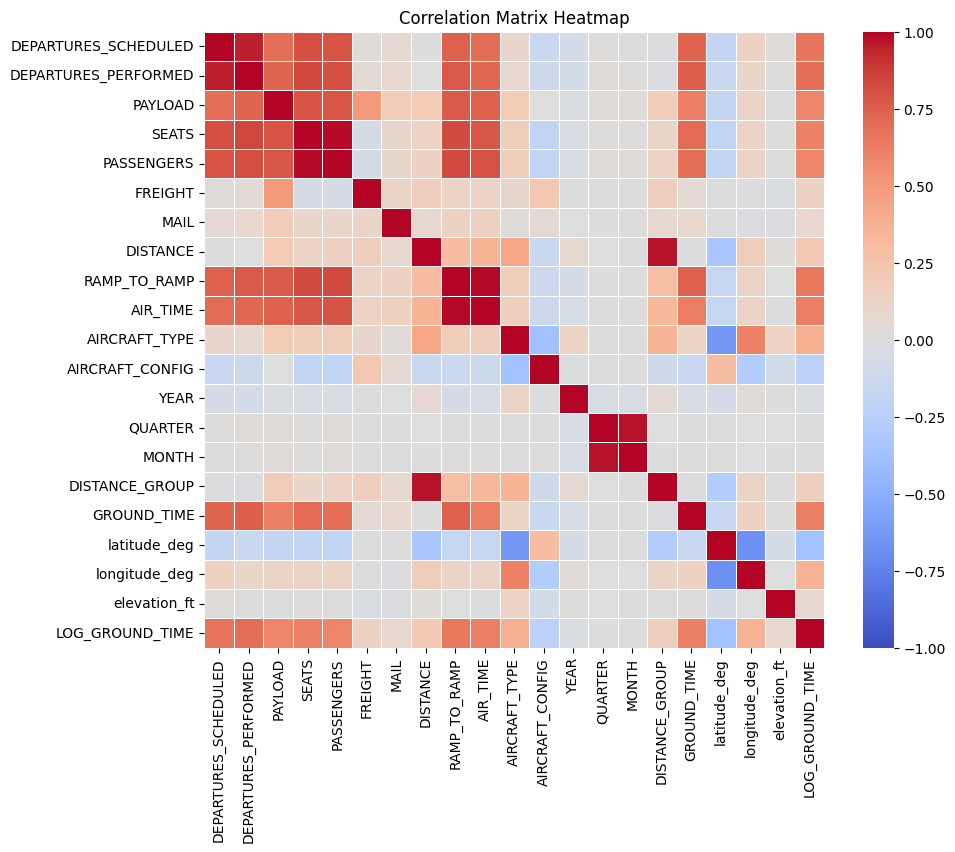

In [20]:
# Select only numerical columns from the DataFrame
df_numerical = df_carrier.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for the numerical columns
correlation_matrix = df_numerical.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Encoding
Encoding is not necessary for the key variables. Below is a rule-based encoding applied on heatmap to improve clarity.

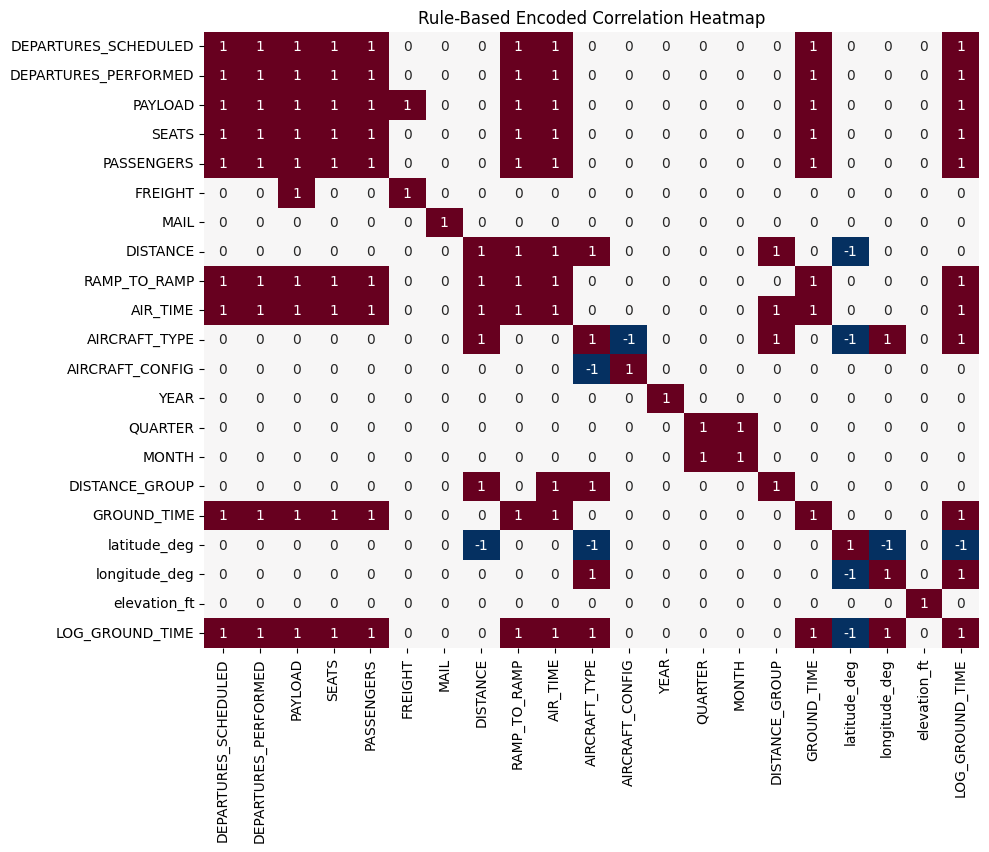

In [21]:
# Define a rule-based encoding for strong and weak correlations
def encode_correlation(corr_matrix, low_threshold=0.3):
    # Apply the encoding based on the rule (0.3 threshold for weak vs. strong)
    encoded_corr = corr_matrix.apply(lambda x: np.where(x <= -low_threshold, -1, np.where(x >= low_threshold, 1, 0)))
    return encoded_corr

# Apply the encoding to the correlation matrix
encoded_corr = encode_correlation(correlation_matrix, low_threshold=0.3)

# Plot the heatmap using a diverging colormap
plt.figure(figsize=(10, 8))
sns.heatmap(encoded_corr, cmap="RdBu_r", center=0, annot=True, cbar=False)
plt.title('Rule-Based Encoded Correlation Heatmap')
plt.show()

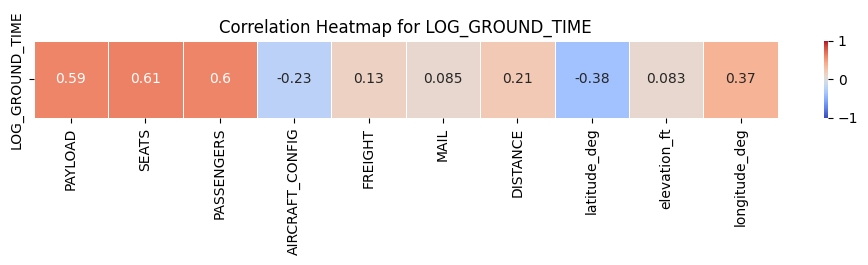

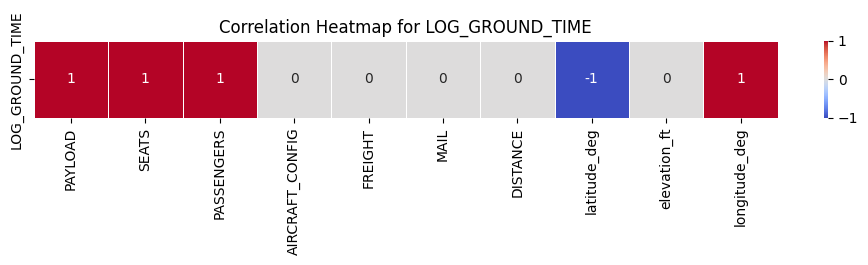

In [22]:
# Filter the correlation matrix to only include the 'LOG_GROUND_TIME' row
predictor_candidate = ['PAYLOAD', 'SEATS', 'PASSENGERS', 'AIRCRAFT_CONFIG', 'FREIGHT', 'MAIL', 'DISTANCE', 'latitude_deg', 'elevation_ft', 'longitude_deg']
log_ground_time_corr = correlation_matrix.loc[['LOG_GROUND_TIME'], predictor_candidate]
log_ground_time_corr_encoded = encoded_corr.loc[['LOG_GROUND_TIME'], predictor_candidate]

# Create a heatmap for the filtered data
plt.figure(figsize=(12, 1)) 
#sns.heatmap(log_ground_time_corr.T, annot=False, cmap='cividis', linewidths=0.5, cbar=True)
sns.heatmap(log_ground_time_corr, annot=True, cmap='coolwarm', linewidths=0.5, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap for LOG_GROUND_TIME')
plt.show()




# Create a heatmap for the filtered data
plt.figure(figsize=(12, 1)) 
#sns.heatmap(log_ground_time_corr.T, annot=False, cmap='cividis', linewidths=0.5, cbar=True)
sns.heatmap(log_ground_time_corr_encoded, annot=True, cmap='coolwarm', linewidths=0.5, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap for LOG_GROUND_TIME')
plt.show()

# Final Semester

Before we start in the final semester part, I'd like to clarify several things:
1. There is 3 datasets, not 1 like the mid-semester feedback:
- First dataset: df_aircraft (Primary)
- Second dataset: tab_L* (Data Dictionary)
- Third dataset: df_airports (Helper)

2. The link for the data can be downloaded from my github, or can be downloaded directly from link below. I mention this in the D2L commentaries but I forgot to put it in the jupyter notebook. The reason for this is the dataset is way too large (4 million of rows). You might want to download from my github since it is faster. Downloading from the datasource need the system to do join first, which will take so much time. I'll also upload it in the D2L. Below is the github link:
- Primary Dataset: aircraft.csv
- Data Dictionary: L_*.csv
- Helper: airport.csv

3. After reviewing the data, there are so many critical mistake which will be explained below. Also, some initial features will be added.

4. As of now, the planned model to be use will be GLM, Random Forest, and Stacked Model.

## Correction on Mid Semester Submission

### Data Standardization
Note that some variables, such as PASSENGERS, FREIGHT, MAIL, RAMP_TO_RAMP, and AIR_TIME should be divided by DEPARTURE_PERFORMED. Dividing by the number of departures gives the average time per flight, to ensure consistent comparisons between periods or across routes. This mistake in the previous submission is an example how a statistician should have knowledge and having sense in the data itself instead of blindly processing the data.



Update: Focus on DTW only since its memory overload in several ocassion during GLM modeling.

In [23]:
df_carrier_standardized = df_carrier.copy()

# Filter to avoid division by zero and modify df_carrier_standardized in place
df_carrier_standardized = df_carrier_standardized[
    df_carrier_standardized['DEPARTURES_PERFORMED'] > 0
]


# Update. Decided to focus on DTW only. Memory overload several times during GLM.
# Filter for DTW
df_carrier_standardized = df_carrier_standardized[
    (df_carrier_standardized['ORIGIN'] == 'DTW') | 
    (df_carrier_standardized['DEST'] == 'DTW')
]


df_carrier_standardized['PASSENGERS'] = df_carrier_standardized['PASSENGERS'] / df_carrier_standardized['DEPARTURES_PERFORMED']
df_carrier_standardized['FREIGHT'] = df_carrier_standardized['FREIGHT'] / df_carrier_standardized['DEPARTURES_PERFORMED']
df_carrier_standardized['MAIL'] = df_carrier_standardized['MAIL'] / df_carrier_standardized['DEPARTURES_PERFORMED']
df_carrier_standardized['RAMP_TO_RAMP'] = df_carrier_standardized['RAMP_TO_RAMP'] / df_carrier_standardized['DEPARTURES_PERFORMED']
df_carrier_standardized['AIR_TIME'] = df_carrier_standardized['AIR_TIME'] / df_carrier_standardized['DEPARTURES_PERFORMED']

# Drop GROUND_TIME and re-add
df_carrier_standardized = df_carrier_standardized.drop(columns=['GROUND_TIME'])
df_carrier_standardized['GROUND_TIME'] = df_carrier_standardized['RAMP_TO_RAMP'] - df_carrier_standardized['AIR_TIME']

# Drop log-ground time, not needed..
df_carrier_standardized = df_carrier_standardized.drop(columns=['LOG_GROUND_TIME'])


# summary = df_carrier_standardized.describe()
# print(summary)

### Predictor Variable (Initial Assessment)
Based on the data, we can expect which variables might have impact. Below is the initial list of candidate variables:
- UNIQUE_CARRIER  
  Airlines might have their own strategies, even within the same company. For example, Singapore Airline (Premium) is owning Scoot Airline (Low-cost). Low-cost carrier may have a shorter ground-time compared to premium one. Or Freight companies like UPS or FedEx might have longer ground time.

- DISTANCE  
  Longer flights require larger airplane which can carry more fuel and require more loads to be efficient, thus affecting ground time.

- LARGE_AIRPORT  
  Larger airports might have better equipment, but vice versa it also might have high traffic.

- PASSENGERS  
More passengers means more complication.

- FREIGHTS  
Same as passengers.

- MAIL  
Same as freights.


In [24]:
df_carrier_standardized = pd.merge(df_carrier_standardized, tab_unique_carriers, left_on="UNIQUE_CARRIER", right_on="Code", how="inner")

# Replace the UNIQUE_CARRIER column with the Description column and drop the original Description column
df_carrier_standardized['UNIQUE_CARRIER'] = df_carrier_standardized['Description'].astype('category')
df_carrier_standardized = df_carrier_standardized.drop(columns=['Description'])

# Check the updated DataFrame
# summary = df_carrier_standardized.describe(include="all")
# print(summary)

In [25]:
df_carrier_standardized.head(10)

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,MONTH,DISTANCE_GROUP,CLASS,latitude_deg,longitude_deg,elevation_ft,type,AIRCRAFT_CONFIG_DESC,GROUND_TIME,Code
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,148.000000,27.000000,...,2,1,F,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,121.000000,NK
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,224.000000,114.000000,...,12,1,F,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,110.000000,NK
2,0.0,1.0,1098.0,10.0,0.0,0.0,0.0,97.0,625.183719,776.280568,...,2,1,L,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,-151.096849,0Q
3,0.0,1.0,2000.0,8.0,3.0,0.0,0.0,1968.0,278.000000,268.000000,...,4,4,L,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,10.000000,0WQ
4,0.0,1.0,3000.0,14.0,0.0,0.0,0.0,369.0,63.000000,58.000000,...,6,1,L,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,5.000000,0WQ
5,0.0,1.0,3000.0,17.0,3.0,0.0,0.0,667.0,115.000000,94.000000,...,3,2,L,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,21.000000,0WQ
6,0.0,1.0,3000.0,17.0,10.0,0.0,0.0,1137.0,153.000000,141.000000,...,3,3,L,25.907000,-80.278397,8.0,medium_airport,Passenger Configuration,12.000000,0WQ
7,0.0,1.0,3274.0,9.0,5.0,0.0,0.0,22.0,30.000000,12.000000,...,1,1,L,42.213770,-83.353786,645.0,large_airport,Passenger Configuration,18.000000,1AQ
8,0.0,1.0,3274.0,9.0,7.0,0.0,0.0,106.0,48.000000,30.000000,...,1,1,L,41.565102,-81.486397,879.0,medium_airport,Passenger Configuration,18.000000,1AQ
9,0.0,1.0,5600.0,0.0,0.0,0.0,0.0,9.0,15.000000,5.000000,...,11,1,P,42.213770,-83.353786,645.0,large_airport,Freight Configuration,10.000000,U7


### Feature Engineering

New boolean variable will be added to improve the GLM model:

- HAS_PASSENGERS
- HAS_FREIGHTS
- HAS_MAIL

In [26]:
# Create HAS_PASSENGERS, HAS_FREIGHTS, HAS_MAIL
df_carrier_standardized['HAS_PASSENGERS'] = np.where(df_carrier_standardized['PASSENGERS'] > 0, 1, 0)
df_carrier_standardized['HAS_FREIGHTS'] = np.where(df_carrier_standardized['FREIGHT'] > 0, 1, 0)
df_carrier_standardized['HAS_MAIL'] = np.where(df_carrier_standardized['MAIL'] > 0, 1, 0)


### Optimization
Since the GLM model doesn't run, we will optimize the model by downcast it to numerical column.

In [27]:
# Identify numerical columns to downcast
numerical_cols = ['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
                  'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
                  'GROUND_TIME']

# Downcast numerical columns
for col in numerical_cols:
    df_carrier_standardized[col] = pd.to_numeric(df_carrier_standardized[col], downcast='float')

Also reducing the UNIQUE_CARRIER number to only top 20.

In [28]:
# Define the number of top carriers to retain
top_n = 20

# Calculate carrier frequencies in the entire dataset
carrier_counts = df_carrier_standardized['UNIQUE_CARRIER'].value_counts()

# Identify top N carriers
top_carriers = carrier_counts.nlargest(top_n).index

# Replace carriers not in top N with 'Other'
df_carrier_standardized['UNIQUE_CARRIER'] = df_carrier_standardized['UNIQUE_CARRIER'].apply(
    lambda x: x if x in top_carriers else 'Other'
)

# Convert 'UNIQUE_CARRIER' to categorical with 'Other' included
df_carrier_standardized['UNIQUE_CARRIER'] = df_carrier_standardized['UNIQUE_CARRIER'].astype('category')

# Verify the number of unique carriers
print(f"Number of UNIQUE_CARRIER categories after grouping: {df_carrier_standardized['UNIQUE_CARRIER'].nunique()}")
print(df_carrier_standardized['UNIQUE_CARRIER'].value_counts())


Number of UNIQUE_CARRIER categories after grouping: 21
UNIQUE_CARRIER
Delta Air Lines Inc.                       45624
Endeavor Air Inc.                          18909
SkyWest Airlines Inc.                      17798
ExpressJet Airlines LLC d/b/a aha!          9973
Spirit Air Lines                            9106
GoJet Airlines LLC d/b/a United Express     5854
Other                                       5319
Southwest Airlines Co.                      4940
Republic Airline                            4274
United Air Lines Inc.                       3302
American Airlines Inc.                      2831
Frontier Airlines Inc.                      2385
Federal Express Corporation                 2371
Shuttle America Corp.                       2185
Compass Airlines                            1481
United Parcel Service                       1261
PSA Airlines Inc.                           1014
JetBlue Airways                              807
Envoy Air                                    753

### Encoding
UNIQUE_CARRIER and LARGE_AIRPORT need encoding. Thus, one-hot-encoding will be applied for UNIQUE_CARRIER and binary encoding for LARGE_AIRPORT. It was a great mistake in the mid-semester to say that encoding is not required. The one-hot encoding has been chosen instead of label and target based on the cons below:
- One-hot encoding  
  cons: take so many spaces
- Label encoding  
  cons: assume order
- Target encoding  
  cons: risk of data leakage

Update: So apparently statsmodel handles the encoding by itself. So the one-hot encoding will be reverted.

In [29]:
# Encode LARGE_AIRPORT as binary
df_carrier_standardized['LARGE_AIRPORT'] = df_carrier_standardized['type'].apply(lambda x: 1 if x == 'large_airport' else 0)

# # One-hot encode UNIQUE_CARRIER (drop one category to avoid multicollinearity)
# df_carrier_standardized = pd.get_dummies(df_carrier_standardized, columns=['UNIQUE_CARRIER'], drop_first=True)


df_carrier_standardized['UNIQUE_CARRIER'] = df_carrier_standardized['UNIQUE_CARRIER'].astype('category')

In [30]:
df_carrier_standardized.head(10)

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,longitude_deg,elevation_ft,type,AIRCRAFT_CONFIG_DESC,GROUND_TIME,Code,HAS_PASSENGERS,HAS_FREIGHTS,HAS_MAIL,LARGE_AIRPORT
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,148.000000,27.000000,...,-83.353786,645.0,large_airport,Passenger Configuration,121.000000,NK,0,0,0,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,224.000000,114.000000,...,-83.353786,645.0,large_airport,Passenger Configuration,110.000000,NK,0,0,0,1
2,0.0,1.0,1098.0,10.0,0.0,0.0,0.0,97.0,625.183716,776.280579,...,-83.353786,645.0,large_airport,Passenger Configuration,-151.096848,0Q,0,0,0,1
3,0.0,1.0,2000.0,8.0,3.0,0.0,0.0,1968.0,278.000000,268.000000,...,-83.353786,645.0,large_airport,Passenger Configuration,10.000000,0WQ,1,0,0,1
4,0.0,1.0,3000.0,14.0,0.0,0.0,0.0,369.0,63.000000,58.000000,...,-83.353786,645.0,large_airport,Passenger Configuration,5.000000,0WQ,0,0,0,1
5,0.0,1.0,3000.0,17.0,3.0,0.0,0.0,667.0,115.000000,94.000000,...,-83.353786,645.0,large_airport,Passenger Configuration,21.000000,0WQ,1,0,0,1
6,0.0,1.0,3000.0,17.0,10.0,0.0,0.0,1137.0,153.000000,141.000000,...,-80.278397,8.0,medium_airport,Passenger Configuration,12.000000,0WQ,1,0,0,0
7,0.0,1.0,3274.0,9.0,5.0,0.0,0.0,22.0,30.000000,12.000000,...,-83.353786,645.0,large_airport,Passenger Configuration,18.000000,1AQ,1,0,0,1
8,0.0,1.0,3274.0,9.0,7.0,0.0,0.0,106.0,48.000000,30.000000,...,-81.486397,879.0,medium_airport,Passenger Configuration,18.000000,1AQ,1,0,0,0
9,0.0,1.0,5600.0,0.0,0.0,0.0,0.0,9.0,15.000000,5.000000,...,-83.353786,645.0,large_airport,Freight Configuration,10.000000,U7,0,0,0,1


### Model Train
The 2024 data will be omitted since the cohort is incomplete.  
Train data: 2014 - 2022  
Test data: 2023  

In [31]:
# Train data: 2014–2022
df_train = df_carrier_standardized[(df_carrier_standardized['YEAR'] >= 2014) & 
                                   (df_carrier_standardized['YEAR'] <= 2022)].copy()

# Test data: 2023
df_test = df_carrier_standardized[df_carrier_standardized['YEAR'] == 2023].copy()

In [32]:
# Summary of data splits
print(f"Training data: {df_train['YEAR'].min()}-{df_train['YEAR'].max()} (n={len(df_train)})")
print(f"Test data: {df_test['YEAR'].min()} (n={len(df_test)})")

Training data: 2014-2022 (n=126351)
Test data: 2023 (n=11171)


### Modeling

#### Baseline
Intercept only model as a benchmark

In [33]:
# Weighted RMSE function
def rmse_weighted(df, predictions):
    weights = df['DEPARTURES_PERFORMED']
    errors = (predictions - df['GROUND_TIME']) ** 2
    return np.sqrt(np.sum(weights * errors) / np.sum(weights))

# Unweighted RMSE function
def rmse_unweighted(df, predictions):
    return np.sqrt(mean_squared_error(df['GROUND_TIME'], predictions))

In [34]:
# Intercept-Only Weighted Model
model_weighted = sm.GLM.from_formula(
    'GROUND_TIME ~ 1',
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Intercept-Only Unweighted Model
model_unweighted = sm.GLM.from_formula(
    'GROUND_TIME ~ 1',
    data=df_train,
    family=sm.families.Gaussian()
).fit()


In [35]:
# Print summaries of both models
print("Weighted Intercept-Only Model Summary:")
print(model_weighted.summary())

print("\nUnweighted Intercept-Only Model Summary:")
print(model_unweighted.summary())

Weighted Intercept-Only Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            GROUND_TIME   No. Observations:               126351
Model:                            GLM   Df Residuals:                  2866222
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          244.12
Method:                          IRLS   Log-Likelihood:            -1.1946e+07
Date:                Tue, 03 Dec 2024   Deviance:                   6.9970e+08
Time:                        10:45:16   Pearson chi2:                 7.00e+08
No. Iterations:                     3   Pseudo R-squ. (CS):          1.415e-12
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

In [36]:
# Predictions for the test dataset using intercept-only models
pred_weighted = model_weighted.predict(df_test)
pred_unweighted = model_unweighted.predict(df_test)

# Calculate RMSE for both models
rmse_w = rmse_weighted(df_test, pred_weighted)
rmse_uw = rmse_unweighted(df_test, pred_unweighted)

# Print RMSE values
print(f"Weighted Intercept-Only RMSE: {rmse_w:.4f}")
print(f"Unweighted Intercept-Only RMSE: {rmse_uw:.4f}")


Weighted Intercept-Only RMSE: 20.1269
Unweighted Intercept-Only RMSE: 94.2967


In [37]:
# Generalized RMSE function for weighted models
def compute_rmse_weighted(df, model, formula):
    """
    Compute weighted RMSE for a given model based on the formula.

    Parameters:
    - df: pandas DataFrame containing the test data.
    - model: Fitted statsmodels GLM model.
    - formula: String formula used to fit the model.

    Returns:
    - Weighted RMSE value.
    """
    predictions = model.predict(df)
    return rmse_weighted(df, predictions)

# Generalized RMSE function for unweighted models
def compute_rmse_unweighted(df, model, formula):
    """
    Compute unweighted RMSE for a given model based on the formula.

    Parameters:
    - df: pandas DataFrame containing the test data.
    - model: Fitted statsmodels GLM model.
    - formula: String formula used to fit the model.

    Returns:
    - Unweighted RMSE value.
    """
    predictions = model.predict(df)
    return rmse_unweighted(df, predictions)


In [38]:
# Compute RMSE using the generalized functions for intercept-only models
weighted_rmse_general = compute_rmse_weighted(df_test, model_weighted, 'GROUND_TIME ~ 1')
unweighted_rmse_general = compute_rmse_unweighted(df_test, model_unweighted, 'GROUND_TIME ~ 1')

# Print RMSE results
print(f"Generalized Weighted RMSE: {weighted_rmse_general:.4f}")
print(f"Generalized Unweighted RMSE: {unweighted_rmse_general:.4f}")


Generalized Weighted RMSE: 20.1269
Generalized Unweighted RMSE: 94.2967


__Grouping__  
Since the UNIQUE_CARRIER contains too much data, the python is error. We need to set a threshold where the smaller carrier will be put as others.

Update: Cancelled. See above, now only take top 20.

In [39]:
# # Define a threshold for minimum number of departures to retain a carrier as a separate category
# threshold = 100  # Adjust based on your data distribution

# # Calculate carrier frequencies in the training set
# carrier_counts = df_carrier_standardized['UNIQUE_CARRIER'].value_counts()

# # Identify carriers to be grouped into 'Other'
# carriers_to_group = carrier_counts[carrier_counts < threshold].index

# # Replace these carriers with 'Other' in the entire dataset
# df_carrier_standardized['UNIQUE_CARRIER'] = df_carrier_standardized['UNIQUE_CARRIER'].cat.add_categories(['Other'])
# df_carrier_standardized['UNIQUE_CARRIER'].replace(carriers_to_group, 'Other', inplace=True)

# # Confirm the reduction in categories
# print(f"Number of UNIQUE_CARRIER categories after grouping: {df_carrier_standardized['UNIQUE_CARRIER'].nunique()}")


#### GLM Model

##### GLM1: UNIQUE_CARRIER

In [40]:
# Define the formula for GLM1
formula_glm1 = 'GROUND_TIME ~ UNIQUE_CARRIER'

# Fit the GLM1 model
glm1 = sm.GLM.from_formula(
    formula_glm1,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Display the model summary
# print("GLM1 - UNIQUE_CARRIER Model Summary:")
# print(glm1.summary())

# Compute RMSE using the generalized functions
weighted_rmse_glm1 = compute_rmse_weighted(df_test, glm1, formula_glm1)
unweighted_rmse_glm1 = compute_rmse_unweighted(df_test, glm1, formula_glm1)

# Print RMSE results
print(f"GLM1 Weighted RMSE: {weighted_rmse_glm1:.4f}")
print(f"GLM1 Unweighted RMSE: {unweighted_rmse_glm1:.4f}")




GLM1 Weighted RMSE: 20.0395
GLM1 Unweighted RMSE: 94.2406


In [41]:
# Print RMSE values
print(f"Weighted Intercept-Only RMSE: {rmse_w:.4f}")
print(f"Unweighted Intercept-Only RMSE: {rmse_uw:.4f}")

Weighted Intercept-Only RMSE: 20.1269
Unweighted Intercept-Only RMSE: 94.2967


glm_1: 20.1269 -> 20.0395

##### GLM2: DISTANCE

In [42]:
# Define the formula for GLM2
formula_glm2 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE'

# Fit the GLM2 model
glm2 = sm.GLM.from_formula(
    formula_glm2,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm2 = compute_rmse_weighted(df_test, glm2, ['UNIQUE_CARRIER', 'DISTANCE'])
unweighted_rmse_glm2 = compute_rmse_unweighted(df_test, glm2, ['UNIQUE_CARRIER', 'DISTANCE'])

# Print RMSE results
print(f"GLM2 Weighted RMSE: {weighted_rmse_glm2:.4f}")
print(f"GLM2 Unweighted RMSE: {unweighted_rmse_glm2:.4f}")

GLM2 Weighted RMSE: 20.0352
GLM2 Unweighted RMSE: 94.2500


glm_2: 20.1269 -> 20.0395 -> 20.0352

In [43]:
# Print RMSE results
print(f"GLM1 Weighted RMSE: {weighted_rmse_glm1:.4f}")
print(f"GLM1 Unweighted RMSE: {unweighted_rmse_glm1:.4f}")

GLM1 Weighted RMSE: 20.0395
GLM1 Unweighted RMSE: 94.2406


##### GLM3: LARGE_AIRPORT

In [44]:
# Define the formula for GLM3
formula_glm3 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT'

# Fit the GLM3 model
glm3 = sm.GLM.from_formula(
    formula_glm3,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm3 = compute_rmse_weighted(df_test, glm3, ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT'])
unweighted_rmse_glm3 = compute_rmse_unweighted(df_test, glm3, ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT'])

# Print RMSE results
print(f"GLM3 Weighted RMSE: {weighted_rmse_glm3:.4f}")
print(f"GLM3 Unweighted RMSE: {unweighted_rmse_glm3:.4f}")

GLM3 Weighted RMSE: 20.0296
GLM3 Unweighted RMSE: 94.2353


glm_3: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296

##### GLM4: HAS_PASSENGERS (reject)

In [45]:
# Define the formula for GLM4
formula_glm4 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + HAS_PASSENGERS'

# Fit the GLM4 model
glm4 = sm.GLM.from_formula(
    formula_glm4,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm4 = compute_rmse_weighted(df_test, glm4, ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS'])
unweighted_rmse_glm4 = compute_rmse_unweighted(df_test, glm4, ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS'])

# Print RMSE results
print(f"GLM4 Weighted RMSE: {weighted_rmse_glm4:.4f}")
print(f"GLM4 Unweighted RMSE: {unweighted_rmse_glm4:.4f}")


GLM4 Weighted RMSE: 20.0290
GLM4 Unweighted RMSE: 94.2279


glm_4: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0290 (reject, insignificant)

##### GLM4: PASSENGERS

In [46]:
# Define the formula for GLM5
formula_glm4 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS'

# Fit the GLM5 model
glm4 = sm.GLM.from_formula(
    formula_glm4,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm4 = compute_rmse_weighted(
    df_test,
    glm4,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS']
)
unweighted_rmse_glm4 = compute_rmse_unweighted(
    df_test,
    glm4,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS']
)

# Print RMSE results
print(f"GLM4 Weighted RMSE: {weighted_rmse_glm4:.4f}")
print(f"GLM4 Unweighted RMSE: {unweighted_rmse_glm4:.4f}")


GLM4 Weighted RMSE: 20.0164
GLM4 Unweighted RMSE: 94.1860


glm_4: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164

##### GLM5: HAS_FREIGHTS (reject)

In [47]:
# Define the formula for GLM5
formula_glm5 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + HAS_FREIGHTS'

# Fit the GLM5 model
glm5 = sm.GLM.from_formula(
    formula_glm5,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5 = compute_rmse_weighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'HAS_FREIGHTS']
)
unweighted_rmse_glm5 = compute_rmse_unweighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'HAS_FREIGHTS']
)

# Print RMSE results
print(f"GLM5 Weighted RMSE: {weighted_rmse_glm5:.4f}")
print(f"GLM5 Unweighted RMSE: {unweighted_rmse_glm5:.4f}")

GLM5 Weighted RMSE: 20.0139
GLM5 Unweighted RMSE: 94.1751


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0139 (reject, insignificant)

##### GLM5: FREIGHTS (reject)

In [48]:
# Define the formula for GLM5
formula_glm5 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + FREIGHT'

# Fit the GLM5 model
glm5 = sm.GLM.from_formula(
    formula_glm5,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5 = compute_rmse_weighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'FREIGHT']
)
unweighted_rmse_glm5 = compute_rmse_unweighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'FREIGHT']
)

# Print RMSE results
print(f"GLM5 Weighted RMSE: {weighted_rmse_glm5:.4f}")
print(f"GLM5 Unweighted RMSE: {unweighted_rmse_glm5:.4f}")


GLM5 Weighted RMSE: 20.0148
GLM5 Unweighted RMSE: 94.1807


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0125 (reject, insignificant)

##### GLM5: HAS_MAIL (reject)

In [49]:
# Define the formula for GLM5
formula_glm5 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + HAS_MAIL'

# Fit the GLM5 model
glm5 = sm.GLM.from_formula(
    formula_glm5,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5 = compute_rmse_weighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'HAS_MAIL']
)
unweighted_rmse_glm5 = compute_rmse_unweighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'HAS_MAIL']
)

# Print RMSE results
print(f"GLM5 Weighted RMSE: {weighted_rmse_glm5:.4f}")
print(f"GLM5 Unweighted RMSE: {unweighted_rmse_glm5:.4f}")


GLM5 Weighted RMSE: 20.0151
GLM5 Unweighted RMSE: 94.1845


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0151 (reject, insignificant)

##### GLM5: MAIL (reject)

In [50]:
# Define the formula for GLM5
formula_glm5 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + MAIL'

# Fit the GLM5 model
glm5 = sm.GLM.from_formula(
    formula_glm5,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5 = compute_rmse_weighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'MAIL']
)
unweighted_rmse_glm5 = compute_rmse_unweighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'MAIL']
)

# Print RMSE results
print(f"GLM5 Weighted RMSE: {weighted_rmse_glm5:.4f}")
print(f"GLM5 Unweighted RMSE: {unweighted_rmse_glm5:.4f}")


GLM5 Weighted RMSE: 20.0170
GLM5 Unweighted RMSE: 94.1858


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0170 (reject, increasing)

##### GLM5: MONTH (reject)

In [51]:
# Define the formula for GLM5
formula_glm5 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + MONTH'

# Fit the GLM5 model
glm5 = sm.GLM.from_formula(
    formula_glm5,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5 = compute_rmse_weighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'MONTH']
)
unweighted_rmse_glm5 = compute_rmse_unweighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'MONTH']
)

# Print RMSE results
print(f"GLM5 Weighted RMSE: {weighted_rmse_glm5:.4f}")
print(f"GLM5 Unweighted RMSE: {unweighted_rmse_glm5:.4f}")


GLM5 Weighted RMSE: 20.0110
GLM5 Unweighted RMSE: 94.1944


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0110 (reject, isolated winter accepted)

##### GLM5: WINTER (accept)

In [52]:
# Add IS_WINTER column to both train and test datasets
df_train['IS_WINTER'] = df_train['MONTH'].apply(lambda x: 1 if x in [12, 1] else 0)
df_test['IS_WINTER'] = df_test['MONTH'].apply(lambda x: 1 if x in [12, 1] else 0)

# Define the formula for GLM5 with IS_WINTER
formula_glm5_winter = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + IS_WINTER'

# Fit the GLM5 model with IS_WINTER
glm5_winter = sm.GLM.from_formula(
    formula_glm5_winter,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5_winter = compute_rmse_weighted(
    df_test,
    glm5_winter,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'IS_WINTER']
)
unweighted_rmse_glm5_winter = compute_rmse_unweighted(
    df_test,
    glm5_winter,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'IS_WINTER']
)

# Print RMSE results
print(f"GLM5 with Winter Isolation Weighted RMSE: {weighted_rmse_glm5_winter:.4f}")
print(f"GLM5 with Winter Isolation Unweighted RMSE: {unweighted_rmse_glm5_winter:.4f}")

GLM5 with Winter Isolation Weighted RMSE: 20.0089
GLM5 with Winter Isolation Unweighted RMSE: 94.1800


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0089 (accepted, selected isolation)

##### GLM5: PEAK_SEASON (reject)

In [53]:
# Add IS_PEAK_SEASON column to both train and test datasets
df_train['IS_PEAK_SEASON'] = df_train['MONTH'].apply(lambda x: 1 if x in [5, 6, 7, 12, 1] else 0)
df_test['IS_PEAK_SEASON'] = df_test['MONTH'].apply(lambda x: 1 if x in [5, 6, 7, 12, 1] else 0)

# Define the formula for GLM5
formula_glm5 = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + PASSENGERS + IS_PEAK_SEASON'

# Fit the GLM5 model
glm5 = sm.GLM.from_formula(
    formula_glm5,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm5 = compute_rmse_weighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'IS_PEAK_SEASON']
)
unweighted_rmse_glm5 = compute_rmse_unweighted(
    df_test,
    glm5,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'PASSENGERS', 'IS_PEAK_SEASON']
)

# Print RMSE results
print(f"GLM5 (Peak Season) Weighted RMSE: {weighted_rmse_glm5:.4f}")
print(f"GLM5 (Peak Season) Unweighted RMSE: {unweighted_rmse_glm5:.4f}")


GLM5 (Peak Season) Weighted RMSE: 20.0162
GLM5 (Peak Season) Unweighted RMSE: 94.1822


glm_5: 20.1269 -> 20.0395 -> 20.0352 -> 20.0296 -> 20.0164 -> 20.0162  (reject, isolated winter accepted)

##### GLM FULL MODEL

Need to re-add the HAS_PASSENGERS since HAS_PASSENGERS is to support PASSENGERS.

In [76]:
# Define the formula for GLM_FULL with IS_WINTER + HAS_PASSENGERS
formula_glm_full = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + HAS_PASSENGERS + PASSENGERS + IS_WINTER'

# Fit the GLM_FULL model with IS_WINTER
glm_full = sm.GLM.from_formula(
    formula_glm_full,
    data=df_train,
    family=sm.families.Gaussian(),
    freq_weights=df_train['DEPARTURES_PERFORMED']
).fit()

# Compute RMSE using the generalized functions
weighted_rmse_glm_full = compute_rmse_weighted(
    df_test,
    glm_full,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS', 'PASSENGERS', 'IS_WINTER']
)
unweighted_rmse_glm_full = compute_rmse_unweighted(
    df_test,
    glm_full,
    ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS', 'PASSENGERS', 'IS_WINTER']
)

# Print RMSE results
print(f"GLM_FULL with Winter Isolation Weighted RMSE: {weighted_rmse_glm_full:.4f}")
print(f"GLM_FULL with Winter Isolation Unweighted RMSE: {unweighted_rmse_glm_full:.4f}")

GLM_FULL with Winter Isolation Weighted RMSE: 20.0091
GLM_FULL with Winter Isolation Unweighted RMSE: 94.1825


##### Drop Test

In [77]:
# Print RMSE values
print(f"Weighted Intercept-Only RMSE: {rmse_w:.4f}")
print(f"Unweighted Intercept-Only RMSE: {rmse_uw:.4f}")

# Print RMSE results
print(f"GLM Full Model Weighted RMSE: {weighted_rmse_glm_full:.4f}")
print(f"GLM Full Model Unweighted RMSE: {unweighted_rmse_glm_full:.4f}")

# Define the full formula for reference
formula_glm_full = 'GROUND_TIME ~ UNIQUE_CARRIER + DISTANCE + LARGE_AIRPORT + HAS_PASSENGERS + PASSENGERS + IS_WINTER'

# Initialize a dictionary to store RMSE results for each drop
drop_test_results = {}

# Define variables to drop one by one
variables_to_drop = ['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS', 'PASSENGERS', 'IS_WINTER']

for var in variables_to_drop:
    # Create the formula without the variable
    formula_drop = 'GROUND_TIME ~ ' + ' + '.join([v for v in variables_to_drop if v != var])

    # Fit the GLM model with the dropped variable
    glm_drop = sm.GLM.from_formula(
        formula_drop,
        data=df_train,
        family=sm.families.Gaussian(),
        freq_weights=df_train['DEPARTURES_PERFORMED']
    ).fit()

    # Compute RMSE
    weighted_rmse = compute_rmse_weighted(df_test, glm_drop, [v for v in variables_to_drop if v != var])
    unweighted_rmse = compute_rmse_unweighted(df_test, glm_drop, [v for v in variables_to_drop if v != var])

    # Store results
    drop_test_results[var] = {
        'Weighted RMSE': round(weighted_rmse, 4),
        'Unweighted RMSE': round(unweighted_rmse, 4)
    }

    # Print the results
    print(f"Drop {var} - Weighted RMSE: {weighted_rmse:.4f}")
    print(f"Drop {var} - Unweighted RMSE: {unweighted_rmse:.4f}")

Weighted Intercept-Only RMSE: 20.1269
Unweighted Intercept-Only RMSE: 94.2967
GLM Full Model Weighted RMSE: 20.0091
GLM Full Model Unweighted RMSE: 94.1825
Drop UNIQUE_CARRIER - Weighted RMSE: 20.1064
Drop UNIQUE_CARRIER - Unweighted RMSE: 94.3032
Drop DISTANCE - Weighted RMSE: 20.0086
Drop DISTANCE - Unweighted RMSE: 94.1913
Drop LARGE_AIRPORT - Weighted RMSE: 20.0135
Drop LARGE_AIRPORT - Unweighted RMSE: 94.1938
Drop HAS_PASSENGERS - Weighted RMSE: 20.0089
Drop HAS_PASSENGERS - Unweighted RMSE: 94.1800
Drop PASSENGERS - Weighted RMSE: 20.0239
Drop PASSENGERS - Unweighted RMSE: 94.2291
Drop IS_WINTER - Weighted RMSE: 20.0165
Drop IS_WINTER - Unweighted RMSE: 94.1878


| **Dropped Variable**         | **Weighted RMSE** | **Unweighted RMSE** | **Difference from Full (Weighted)** | **Difference from Full (Unweighted)** |
|------------------------------|--------------------|----------------------|--------------------------------------|----------------------------------------|
| **Full Model (GLM Full)**    | 20.0091           | 94.1825             | 0.0000                               | 0.0000                                 |
| Drop `UNIQUE_CARRIER`        | 20.1064           | 94.3032             | +0.0973                              | +0.1207                                |
| Drop `DISTANCE`              | 20.0086           | 94.1913             | -0.0005                              | +0.0088                                |
| Drop `LARGE_AIRPORT`         | 20.0135           | 94.1938             | +0.0044                              | +0.0113                                |
| Drop `HAS_PASSENGERS`        | 20.0089           | 94.1800             | -0.0002                              | -0.0025                                |
| Drop `PASSENGERS`            | 20.0239           | 94.2291             | +0.0148                              | +0.0466                                |
| Drop `IS_WINTER`             | 20.0165           | 94.1878             | +0.0074                              | +0.0053                                |
| **Intercept-Only Model**     | 20.1269           | 94.2967             | +0.1178                              | +0.1142                                |



Based on the drop test above, retain all the variables since removing any of them results in noticable higher RMSEs. For distance, it has no significant impact, its reasonable to keep as it is a significant feature.


##### GLM Final Model Residual

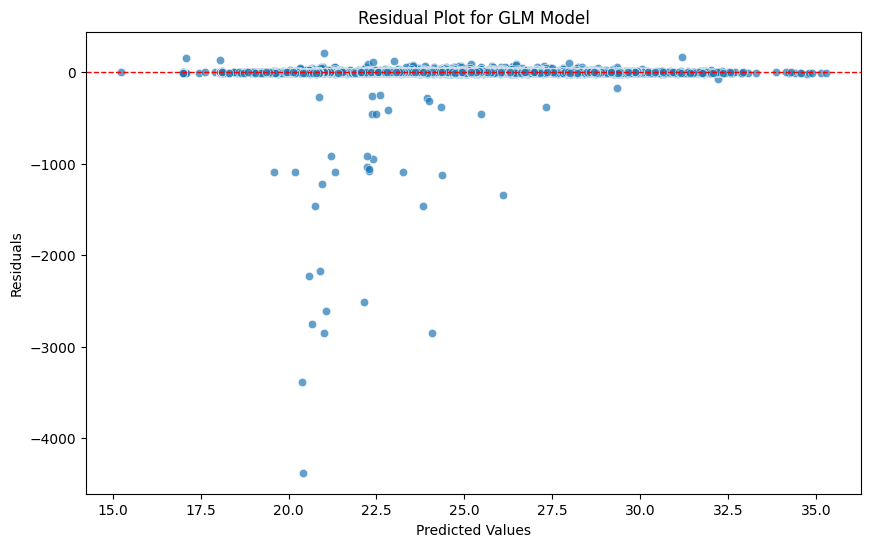

In [78]:
# Predict on test data
glm_preds = glm_full.predict(df_test[['UNIQUE_CARRIER', 'DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS', 'PASSENGERS', 'IS_WINTER']])

# Calculate residuals
residuals = df_test['GROUND_TIME'] - glm_preds

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=glm_preds, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for GLM Model")
plt.show()

Based on the residual plot above, it is indicates that the GLM has similarly distributed errors across the range of predictions between 15 to 35 minutes. However, there are significant outliers in the residual. This indicates that the model has difficulties fitting some of the observation.

##### GLM Model Summary
| GLM Model        | Variables Added             | Deviation (Start -> End)  | Improvement    | Status                                      |
|-------------------|-----------------------------|---------------------------|----------------|---------------------------------------------|
| GLM 0            | INTERCEPT_ONLY              | 20.1269                   | N/A            | Initial model                               |
| GLM 1            | UNIQUE_CARRIER             | 20.1269 -> 20.0395        | -0.0874        | Accepted                                    |
| GLM 2            | DISTANCE                   | 20.0395 -> 20.0352        | -0.0043        | Accepted                                    |
| GLM 3            | LARGE_AIRPORT              | 20.0352 -> 20.0296        | -0.0056        | Accepted                                    |
| GLM 4A           | HAS_PASSENGERS             | 20.0296 -> 20.0290        | -0.0006        | Rejected (insignificant)                   |
| GLM 4B           | PASSENGERS                 | 20.0296 -> 20.0164        | -0.0132        | Accepted                                    |
| GLM 5A           | HAS_FREIGHTS               | 20.0164 -> 20.0139        | -0.0025        | Rejected (insignificant)                   |
| GLM 5B           | FREIGHTS                   | 20.0164 -> 20.0125        | -0.0039        | Rejected (insignificant)                   |
| GLM 5C           | HAS_MAIL                   | 20.0164 -> 20.0151        | -0.0013        | Rejected (insignificant)                   |
| GLM 5D           | MAIL                       | 20.0164 -> 20.0170        | +0.0006        | Rejected (increasing)                      |
| GLM 5E           | MONTH                      | 20.0164 -> 20.0110        | -0.0054        | Rejected (isolated winter accepted)        |
| GLM 5F           | IS_WINTER                     | 20.0164 -> 20.0089        | -0.0075        | Accepted (selected isolation)              |
| GLM 5G           | PEAK_SEASON                | 20.0164 -> 20.0162        | -0.0002        | Rejected (isolated winter accepted)        |
| GLM FULL MODEL   | FULL + HAS_PASSENGERS        | 20.1269 -> 20.0091        | -0.1178        | Final model                                |

HAS_PASSENGERS is added in the final GLM model to support the PASSENGERS even though it's slightly worsen the model as of right now.  
Based on the test above, we accept UNIQUE_CARRIER, DISTANCE, LARGE_AIRPORT, HAS_PASSENGERS, PASSENGERS, and IS_WINTER

In [136]:
# Print summaries of both models
print("GLM Full Model Summary:")
print(glm_full.summary())

GLM Full Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            GROUND_TIME   No. Observations:               126351
Model:                            GLM   Df Residuals:                  2866197
Model Family:                Gaussian   Df Model:                           25
Link Function:               Identity   Scale:                          239.03
Method:                          IRLS   Log-Likelihood:            -1.1916e+07
Date:                Wed, 04 Dec 2024   Deviance:                   6.8512e+08
Time:                        12:50:01   Pearson chi2:                 6.85e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3829
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

1. Model Fitness
- Pseudo R-squared: At 0.3829, it shows a significant improvement over the intercept-only model, but the model still doesn't explain majority of the variability in the dependent variable.  
- Chi-squared: It is expected to have large numbers due to huge amount of samples.

2. Predictors  
- UNIQUE_CARRIER: Most carrier coefficients are highly significant (P < 0.05), with varying impacts on GROUND_TIME.
    - American Airlines Inc. increases GROUND_TIME by 0.9752.
    - Southwest Airlines Co. reduces it significantly by -7.3822.
    - Envoy Air has a substantial positive effect +6.6744.
    - Carriers like Delta Air Lines Inc. (-3.1608) and Spirit Air Lines (-3.9735) significantly reduce GROUND_TIME.
    - Other carriers tend to reduce GROUND_TIME by -2.5068.
- DISTANCE: Small but significant (-0.0004). Distances are weakly correlated with GROUND_TIME, possibly due to different operational practices or scheduling priorities for long-haul flights.  
- AIRPORT_SIZE: Larger airports tend to have longer GROUND_TIME (+1.1324), possibly due to increased traffic, congestion, or more complex procedure.  
- IS_WINTER: Winter months contribute to longer GROUND_TIME (+3.0632), likely due to de-icing procedures, bad weather, or additional safety checks.
- PASSENGERS: Each passenger increases GROUND_TIME by 0.0321 minutes, reflecting boarding and deplaning times.
- HAS_PASSENGERS: Flights without passengers (Freight) have shorter GROUND_TIME by -0.6246 minutes.


##### Bayesian GLM
Key Advantages of Bayesian GLM:  
Uncertainty Quantification: The Bayesian model provides not only point estimates but also the uncertainty (posterior distributions) of the coefficients and predictions.  
Prior Incorporation: You can add prior knowledge about variables, such as expected ranges for coefficients.  
Predictive Distributions: Allows you to generate full predictive distributions for more robust decision-making.  

In [56]:
# # Data preparation
# train_data = df_train.copy()
# test_data = df_test.copy()

# # Standardize numerical predictors (optional, improves sampling performance)
# for col in ['DISTANCE', 'PASSENGERS']:
#     train_data[f'{col}_std'] = (train_data[col] - train_data[col].mean()) / train_data[col].std()
#     test_data[f'{col}_std'] = (test_data[col] - train_data[col].mean()) / train_data[col].std()

# # Bayesian model
# with pm.Model() as bayesian_glm:
#     # Priors for coefficients
#     intercept = pm.Normal('Intercept', mu=0, sigma=10)
#     beta_distance = pm.Normal('Beta_Distance', mu=0, sigma=10)
#     beta_large_airport = pm.Normal('Beta_Large_Airport', mu=0, sigma=10)
#     beta_passengers = pm.Normal('Beta_Passengers', mu=0, sigma=10)
#     beta_is_winter = pm.Normal('Beta_IS_WINTER', mu=0, sigma=10)
    
#     # UNIQUE_CARRIER as a categorical variable
#     carrier_coeffs = pm.Normal('Carrier_Coeffs', mu=0, sigma=10, shape=train_data['UNIQUE_CARRIER'].nunique())
#     carrier_idx = train_data['UNIQUE_CARRIER'].cat.codes.values

#     # Linear model
#     mu = (intercept +
#           beta_distance * train_data['DISTANCE_std'] +
#           beta_large_airport * train_data['LARGE_AIRPORT'] +
#           beta_passengers * train_data['PASSENGERS_std'] +
#           beta_is_winter * train_data['IS_WINTER'] +
#           carrier_coeffs[carrier_idx])

#     # Likelihood
#     sigma = pm.HalfNormal('Sigma', sigma=10)
#     ground_time = pm.Normal('GROUND_TIME', mu=mu, sigma=sigma, observed=train_data['GROUND_TIME'])
    
#     # Sampling
#     trace = pm.sample(2000, return_inferencedata=True)

# # Summarize results
# az.summary(trace, hdi_prob=0.95)

Reduce the number of chains and iteration, also take 20% of samples from each set to improve performance.

In [63]:
# # Data preparation
# train_data = df_train.copy()
# test_data = df_test.copy()

# # Subset the data to reduce size (Option 2)
# train_data = train_data.sample(frac=0.2, random_state=42)  # Use 20% of the training data
# test_data = test_data.sample(frac=0.2, random_state=42)  # Use 20% of the test data

# # Standardize numerical predictors (Optional, improves sampling performance)
# for col in ['DISTANCE', 'PASSENGERS']:
#     train_data[f'{col}_std'] = (train_data[col] - train_data[col].mean()) / train_data[col].std()
#     test_data[f'{col}_std'] = (test_data[col] - train_data[col].mean()) / train_data[col].std()

# # Bayesian model with optimizations
# with pm.Model() as bayesian_glm:
#     # Priors for coefficients
#     intercept = pm.Normal('Intercept', mu=0, sigma=10)
#     beta_distance = pm.Normal('Beta_Distance', mu=0, sigma=10)
#     beta_large_airport = pm.Normal('Beta_Large_Airport', mu=0, sigma=10)
#     beta_passengers = pm.Normal('Beta_Passengers', mu=0, sigma=10)
#     beta_is_winter = pm.Normal('Beta_IS_WINTER', mu=0, sigma=10)
    
#     # UNIQUE_CARRIER as a categorical variable
#     carrier_coeffs = pm.Normal('Carrier_Coeffs', mu=0, sigma=10, shape=train_data['UNIQUE_CARRIER'].nunique())
#     carrier_idx = train_data['UNIQUE_CARRIER'].cat.codes.values

#     # Linear model
#     mu = (intercept +
#           beta_distance * train_data['DISTANCE_std'] +
#           beta_large_airport * train_data['LARGE_AIRPORT'] +
#           beta_passengers * train_data['PASSENGERS_std'] +
#           beta_is_winter * train_data['IS_WINTER'] +
#           carrier_coeffs[carrier_idx])

#     # Likelihood
#     sigma = pm.HalfNormal('Sigma', sigma=10)
#     ground_time = pm.Normal('GROUND_TIME', mu=mu, sigma=sigma, observed=train_data['GROUND_TIME'])

#     # Sampling with fewer iterations and chains (Option 1)
#     trace = pm.sample(1000, chains=2, tune=500, return_inferencedata=True)

# # Summarize results
# az.summary(trace, hdi_prob=0.95)

In [ ]:
# # Data preparation
# train_data = df_train.copy()
# test_data = df_test.copy()

# # **1. Subset the data to reduce size**
# # Use 20% of the training and testing data
# train_data = train_data.sample(frac=0.2, random_state=42)
# test_data = test_data.sample(frac=0.2, random_state=42)

# # Standardize numerical predictors (optional, improves sampling performance)
# for col in ['DISTANCE', 'PASSENGERS']:
#     train_data[f'{col}_std'] = (train_data[col] - train_data[col].mean()) / train_data[col].std()
#     test_data[f'{col}_std'] = (test_data[col] - train_data[col].mean()) / train_data[col].std()

# # **2. Bayesian model using variational inference with reduced iterations**
# with pm.Model() as bayesian_glm_vi:
#     # Priors for coefficients
#     intercept = pm.Normal('Intercept', mu=0, sigma=10)
#     beta_distance = pm.Normal('Beta_Distance', mu=0, sigma=10)
#     beta_large_airport = pm.Normal('Beta_Large_Airport', mu=0, sigma=10)
#     beta_passengers = pm.Normal('Beta_Passengers', mu=0, sigma=10)
#     beta_is_winter = pm.Normal('Beta_IS_WINTER', mu=0, sigma=10)
    
#     # Encode UNIQUE_CARRIER as categorical variable
#     carrier_codes, uniques = pd.factorize(train_data['UNIQUE_CARRIER'])
#     carrier_coeffs = pm.Normal('Carrier_Coeffs', mu=0, sigma=10, shape=len(uniques))
    
#     # Linear model
#     mu = (intercept +
#           beta_distance * train_data['DISTANCE_std'] +
#           beta_large_airport * train_data['LARGE_AIRPORT'] +
#           beta_passengers * train_data['PASSENGERS_std'] +
#           beta_is_winter * train_data['IS_WINTER'] +
#           carrier_coeffs[carrier_codes])
    
#     # Likelihood
#     sigma = pm.HalfNormal('Sigma', sigma=10)
#     ground_time = pm.Normal('GROUND_TIME', mu=mu, sigma=sigma, observed=train_data['GROUND_TIME'])
    
#     # **Reduce n in variational inference**
#     approx = pm.fit(n=5000, method='advi')  # Reduced n from 10000 to 5000

# # Summary of the approximate posterior
# approx_trace = approx.sample(5000)
# az.summary(approx_trace, hdi_prob=0.95)


Output()

Interrupted at 12 [0%]: Average Loss = 1.6196e+06
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.012,0.702,-1.391,1.340,0.010,0.007,5168.0,4974.0,NaN
Beta_Distance,0.005,0.685,-1.292,1.382,0.010,0.007,4674.0,4528.0,NaN
Beta_Large_Airport,0.008,0.691,-1.326,1.330,0.010,0.007,4922.0,4491.0,NaN
Beta_Passengers,0.012,0.685,-1.336,1.316,0.010,0.007,5136.0,4891.0,NaN
Beta_IS_WINTER,-0.007,0.684,-1.277,1.333,0.010,0.007,4673.0,4699.0,NaN
Carrier_Coeffs[0],0.011,0.693,-1.297,1.413,0.010,0.007,5104.0,5155.0,NaN
Carrier_Coeffs[1],-0.014,0.692,-1.349,1.349,0.010,0.007,5037.0,4964.0,NaN
Carrier_Coeffs[2],0.016,0.704,-1.271,1.452,0.010,0.007,4471.0,4826.0,NaN
Carrier_Coeffs[3],0.001,0.685,-1.291,1.390,0.010,0.007,4522.0,4980.0,NaN
Carrier_Coeffs[4],0.003,0.704,-1.405,1.348,0.010,0.007,4877.0,4832.0,NaN


#### Random Forest

##### Random Forest Testing

In [80]:
# Define a function for weighted RMSE
def weighted_rmse(y_true, y_pred, weights):
    return np.sqrt(np.sum(weights * (y_true - y_pred) ** 2) / np.sum(weights))

# Ensure df_train and df_test are prepared and processed
train_data = df_train.copy()
test_data = df_test.copy()

# Convert categorical variables into dummy/indicator variables (one-hot encoding)
train_data = pd.get_dummies(train_data, columns=['UNIQUE_CARRIER'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['UNIQUE_CARRIER'], drop_first=True)

# Align columns of test data with train data
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

# Define predictors and response variable
predictors = ['DISTANCE', 'LARGE_AIRPORT', 'HAS_PASSENGERS', 'PASSENGERS', 'IS_WINTER'] + \
             [col for col in train_data.columns if col.startswith('UNIQUE_CARRIER_')]
response = 'GROUND_TIME'

# Test different mtry (max_features) values
results = {}
for mtry in [1, 2, 3]:
    print(f"Testing mtry (max_features) = {mtry}")
    rf = RandomForestRegressor(n_estimators=100, max_features=mtry, random_state=153)
    rf.fit(train_data[predictors], train_data[response])
    predictions = rf.predict(test_data[predictors])

    # Compute RMSE
    weights = test_data['DEPARTURES_PERFORMED']
    weighted_rmse_val = weighted_rmse(test_data[response], predictions, weights)
    unweighted_rmse_val = np.sqrt(mean_squared_error(test_data[response], predictions))

    results[f'mtry_{mtry}'] = {
        'Weighted RMSE': weighted_rmse_val,
        'Unweighted RMSE': unweighted_rmse_val
    }

    print(f"mtry = {mtry} - Weighted RMSE: {weighted_rmse_val:.4f}")
    print(f"mtry = {mtry} - Unweighted RMSE: {unweighted_rmse_val:.4f}")

# Test different ntree (n_estimators) values
for ntree in [100, 150, 200]:
    print(f"Testing ntree (n_estimators) = {ntree}")
    rf = RandomForestRegressor(n_estimators=ntree, max_features=2, random_state=153)
    rf.fit(train_data[predictors], train_data[response])
    predictions = rf.predict(test_data[predictors])

    # Compute RMSE
    weights = test_data['DEPARTURES_PERFORMED']
    weighted_rmse_val = weighted_rmse(test_data[response], predictions, weights)
    unweighted_rmse_val = np.sqrt(mean_squared_error(test_data[response], predictions))

    results[f'ntree_{ntree}'] = {
        'Weighted RMSE': weighted_rmse_val,
        'Unweighted RMSE': unweighted_rmse_val
    }

    print(f"ntree = {ntree} - Weighted RMSE: {weighted_rmse_val:.4f}")
    print(f"ntree = {ntree} - Unweighted RMSE: {unweighted_rmse_val:.4f}")

# Optional: Test different configurations like `replace=False`
rf = RandomForestRegressor(n_estimators=150, max_features=2, random_state=153, bootstrap=False)
rf.fit(train_data[predictors], train_data[response])
predictions = rf.predict(test_data[predictors])

# Compute RMSE
weighted_rmse_val = weighted_rmse(test_data[response], predictions, weights)
unweighted_rmse_val = np.sqrt(mean_squared_error(test_data[response], predictions))

print(f"Non-replacement RF - Weighted RMSE: {weighted_rmse_val:.4f}")
print(f"Non-replacement RF - Unweighted RMSE: {unweighted_rmse_val:.4f}")

Testing mtry (max_features) = 1
mtry = 1 - Weighted RMSE: 22.7337
mtry = 1 - Unweighted RMSE: 102.2232
Testing mtry (max_features) = 2
mtry = 2 - Weighted RMSE: 22.5306
mtry = 2 - Unweighted RMSE: 101.6853
Testing mtry (max_features) = 3
mtry = 3 - Weighted RMSE: 22.5759
mtry = 3 - Unweighted RMSE: 102.1483
Testing ntree (n_estimators) = 100
ntree = 100 - Weighted RMSE: 22.5306
ntree = 100 - Unweighted RMSE: 101.6853
Testing ntree (n_estimators) = 150
ntree = 150 - Weighted RMSE: 22.6052
ntree = 150 - Unweighted RMSE: 101.9057
Testing ntree (n_estimators) = 200
ntree = 200 - Weighted RMSE: 22.6405
ntree = 200 - Unweighted RMSE: 102.0619
Non-replacement RF - Weighted RMSE: 25.9697
Non-replacement RF - Unweighted RMSE: 115.3067


##### Random Forest Testing Results

| Parameter Type        | Parameter Value | Weighted RMSE  | Unweighted RMSE |
|-----------------------|-----------------|----------------|-----------------|
| **mtry (max_features)** | 1               | 22.7337        | 102.2232        |
|                       | 2               | 22.5306        | 101.6853        |
|                       | 3               | 22.5759        | 102.1483        |
| **ntree (n_estimators)** | 100             | 22.5306        | 101.6853        |
|                       | 150             | 22.6052        | 101.9057        |
|                       | 200             | 22.6405        | 102.0619        |
| **Non-replacement RF** | N/A             | 25.9697        | 115.3067        |

The best Weighted RMSE is observed with mtry = 2 and ntree = 100 (22.5306).  
The best Unweighted RMSE is also achieved with mtry = 2 and ntree = 100 (101.6853).  
Non-replacement Random Forest shows higher RMSE values, indicating poorer performance compared to other configurations.  
<br>
mtry = 2 and ntree = 100 is selected based on this testing.


In [81]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, random_state=153)
rf.fit(train_data[predictors], train_data[response])
predictions = rf.predict(test_data[predictors])

##### Drop Testing

In [82]:
# Drop Testing
drop_test_results = {}
seed = 153

# Baseline RMSE with all predictors
rf_baseline = RandomForestRegressor(random_state=seed, n_estimators=100, max_features=2)
rf_baseline.fit(train_data[predictors], train_data[response])
baseline_preds = rf_baseline.predict(test_data[predictors])
baseline_rmse_weighted = weighted_rmse(test_data[response], baseline_preds, test_data['DEPARTURES_PERFORMED'])
print(f"Baseline Weighted RMSE: {baseline_rmse_weighted:.4f}")

# Exclude UNIQUE_CARRIER from drop testing
variables_to_test = [var for var in predictors if not var.startswith('UNIQUE_CARRIER_')]

# Drop one variable at a time
for var in variables_to_test:
    # Prepare the reduced set of predictors
    predictors_drop = [v for v in predictors if v != var]
    
    # Fit random forest model without the dropped variable
    rf_drop = RandomForestRegressor(random_state=seed, n_estimators=100, max_features=2)
    rf_drop.fit(train_data[predictors_drop], train_data[response])
    
    # Predict and calculate RMSE
    drop_preds = rf_drop.predict(test_data[predictors_drop])
    drop_rmse_weighted = weighted_rmse(test_data[response], drop_preds, test_data['DEPARTURES_PERFORMED'])
    
    # Store results
    drop_test_results[var] = {
        "Weighted RMSE": drop_rmse_weighted,
        "Difference from Baseline": drop_rmse_weighted - baseline_rmse_weighted
    }
    print(f"Drop {var} - Weighted RMSE: {drop_rmse_weighted:.4f}")

# Create a summary DataFrame of the results
drop_test_results_df = pd.DataFrame.from_dict(drop_test_results, orient='index').reset_index()
drop_test_results_df.rename(columns={'index': 'Dropped Variable'}, inplace=True)
print(drop_test_results_df)

Baseline Weighted RMSE: 22.5306
Drop DISTANCE - Weighted RMSE: 22.8714
Drop LARGE_AIRPORT - Weighted RMSE: 22.5250
Drop HAS_PASSENGERS - Weighted RMSE: 21.9451
Drop PASSENGERS - Weighted RMSE: 22.3390
Drop IS_WINTER - Weighted RMSE: 22.0356
  Dropped Variable  Weighted RMSE  Difference from Baseline
0         DISTANCE      22.871374                  0.340795
1    LARGE_AIRPORT      22.524990                 -0.005590
2   HAS_PASSENGERS      21.945064                 -0.585516
3       PASSENGERS      22.339048                 -0.191531
4        IS_WINTER      22.035582                 -0.494998


##### Drop Testing Results for Weighted RMSE

| Dropped Variable  | Weighted RMSE | Difference from Baseline |
|-------------------|---------------|---------------------------|
| None (Baseline)   | 22.5306       | 0.0000                   |
| DISTANCE          | 22.8714       | +0.3408                  |
| LARGE_AIRPORT     | 22.5250       | -0.0056                  |
| HAS_PASSENGERS    | 21.9451       | -0.5855                  |
| PASSENGERS        | 22.3390       | -0.1915                  |
| IS_WINTER         | 22.0356       | -0.4950                  |

Based on the drop testing, dropping `HAS_PASSENGERS` significantly improves performance, but logically, this variable makes sense as a predictor together with `PASSENGERS`. Therefore, I decided to keep it. Similarly, all other variables like `IS_WINTER` contribute meaningfully, and none should be dropped to maintain predictive accuracy and logical consistency.

##### Variable Importance

In [83]:
# Retrieve feature importance
importance = rf.feature_importances_

# Combine predictors and their importance into a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(importance_df)

                                              Feature  Importance
0                                            DISTANCE    0.540547
3                                          PASSENGERS    0.341734
16                               UNIQUE_CARRIER_Other    0.049398
4                                           IS_WINTER    0.019901
2                                      HAS_PASSENGERS    0.017056
1                                       LARGE_AIRPORT    0.015274
8                 UNIQUE_CARRIER_Delta Air Lines Inc.    0.005022
20               UNIQUE_CARRIER_SkyWest Airlines Inc.    0.002996
12         UNIQUE_CARRIER_Federal Express Corporation    0.001800
22                    UNIQUE_CARRIER_Spirit Air Lines    0.001192
9                    UNIQUE_CARRIER_Endeavor Air Inc.    0.000822
23               UNIQUE_CARRIER_United Air Lines Inc.    0.000745
11  UNIQUE_CARRIER_ExpressJet Airlines LLC d/b/a aha!    0.000584
21              UNIQUE_CARRIER_Southwest Airlines Co.    0.000551
18        

| #  | Feature                                              | Importance |
|----|------------------------------------------------------|------------|
| 1  | DISTANCE                                             | 0.540547   |
| 2  | PASSENGERS                                           | 0.341734   |
| 3  | UNIQUE_CARRIER_Other                                 | 0.049398   |
| 4  | IS_WINTER                                            | 0.019901   |
| 5  | HAS_PASSENGERS                                       | 0.017056   |
| 6  | LARGE_AIRPORT                                        | 0.015274   |
| 7  | UNIQUE_CARRIER_Delta Air Lines Inc.                 | 0.005022   |
| 8  | UNIQUE_CARRIER_SkyWest Airlines Inc.                | 0.002996   |
| 9  | UNIQUE_CARRIER_Federal Express Corporation          | 0.001800   |
| 10 | UNIQUE_CARRIER_Spirit Air Lines                     | 0.001192   |
| 11 | UNIQUE_CARRIER_Endeavor Air Inc.                    | 0.000822   |
| 12 | UNIQUE_CARRIER_United Air Lines Inc.                | 0.000745   |
| 13 | UNIQUE_CARRIER_ExpressJet Airlines LLC d/b/a aha!   | 0.000584   |
| 14 | UNIQUE_CARRIER_Southwest Airlines Co.               | 0.000551   |
| 15 | UNIQUE_CARRIER_Republic Airline                     | 0.000482   |
| 16 | UNIQUE_CARRIER_United Parcel Service                | 0.000470   |
| 17 | UNIQUE_CARRIER_Envoy Air                            | 0.000261   |
| 18 | UNIQUE_CARRIER_JetBlue Airways                      | 0.000257   |
| 19 | UNIQUE_CARRIER_American Airlines Inc.               | 0.000204   |
| 20 | UNIQUE_CARRIER_GoJet Airlines LLC d/b/a United...   | 0.000179   |
| 21 | UNIQUE_CARRIER_Shuttle America Corp.                | 0.000158   |
| 22 | UNIQUE_CARRIER_PSA Airlines Inc.                    | 0.000120   |
| 23 | UNIQUE_CARRIER_Compass Airlines                     | 0.000090   |
| 24 | UNIQUE_CARRIER_Frontier Airlines Inc.               | 0.000088   |
| 25 | UNIQUE_CARRIER_Chautauqua Airlines Inc.             | 0.000070   |


##### Partial Dependence

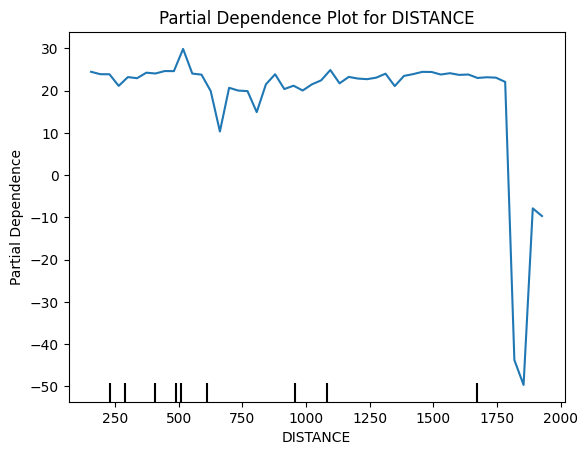

In [84]:
# Create partial dependence plot for "DISTANCE"
PartialDependenceDisplay.from_estimator(
    rf,
    test_data[predictors],  # Feature data to compute dependence
    features=['DISTANCE'],  # Variable for which to compute partial dependence
    grid_resolution=50,     # Number of points in the grid for evaluation
    kind="average",         # Averaging method for the partial dependence
)

# Add rug plot for visual clarity
plt.title("Partial Dependence Plot for DISTANCE")
plt.xlabel("DISTANCE")
plt.ylabel("Partial Dependence")
plt.show()

At lower DISTANCE values, the partial dependence remains consistent.  
Around 1750, the prediction drops sharply, indicating a threshold where "DISTANCE" significantly reduces the predicted value, then recovered quickly. This indicates a subset of data with certain behaviour.

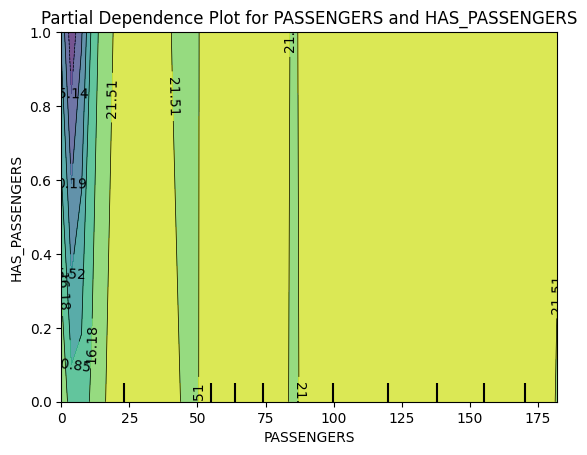

In [85]:
# Create partial dependence plot for "PASSENGERS" and "HAS_PASSENGERS"
PartialDependenceDisplay.from_estimator(
    rf,  # Trained Random Forest model
    test_data[predictors],  # Feature data
    features=[('PASSENGERS', 'HAS_PASSENGERS')],  # Pair of features for 2D plot
    grid_resolution=50,  # Resolution for the grid
    kind="average",  # Averaging method for the partial dependence
)

# Add title and labels
plt.title("Partial Dependence Plot for PASSENGERS and HAS_PASSENGERS")
plt.xlabel("PASSENGERS")
plt.ylabel("HAS_PASSENGERS")
plt.show()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


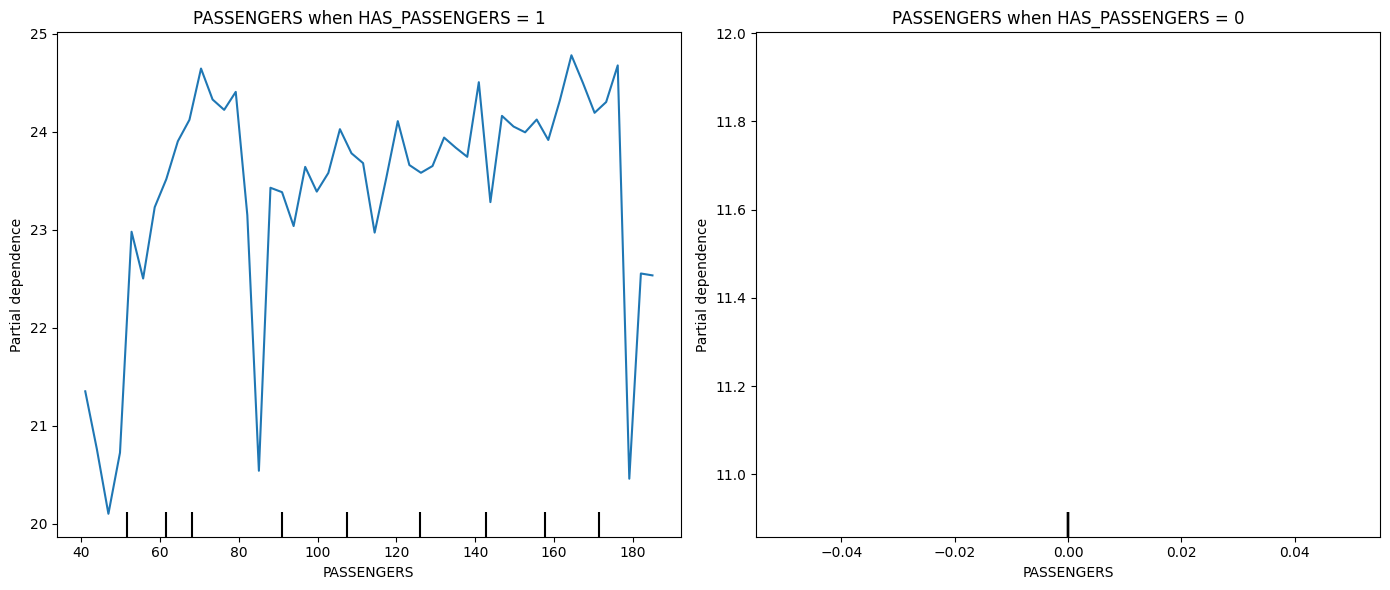

In [102]:

# Subset test data where HAS_PASSENGERS = 1 and HAS_PASSENGERS = 0
test_data_has_passengers = test_data[test_data['HAS_PASSENGERS'] == 1]
test_data_no_passengers = test_data[test_data['HAS_PASSENGERS'] == 0]

# Create a figure for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot partial dependence for HAS_PASSENGERS = 1
disp1 = PartialDependenceDisplay.from_estimator(
    rf,  # Random Forest model
    test_data_has_passengers[predictors],
    ['PASSENGERS'],
    grid_resolution=50,
    ax=ax[0]
)
ax[0].set_title("PASSENGERS when HAS_PASSENGERS = 1")

# Plot partial dependence for HAS_PASSENGERS = 0
disp2 = PartialDependenceDisplay.from_estimator(
    rf,
    test_data_no_passengers[predictors],
    ['PASSENGERS'],
    grid_resolution=50,
    ax=ax[1]
)
ax[1].set_title("PASSENGERS when HAS_PASSENGERS = 0")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The partial dependence plots (PDPs) show how PASSENGERS influences GROUND_TIME, separated by the binary variable HAS_PASSENGERS.

The GROUND_TIME generally increases as the number of PASSENGERS increases. There are fluctuations in the dependence (85, 180), which might be due to variations in the data or interactions with other features.  

The second plot shows no meaningful values for PASSENGERS because it doesn't make sense to have passengers (PASSENGERS > 0) when HAS_PASSENGERS = 0. This behavior highlights the limitation of PDPs for certain predictors when logical relationships (e.g., HAS_PASSENGERS = 0 implying PASSENGERS = 0) exist in the data.

In [110]:
# Extract coefficients and intercept from the GLM
glm_coeffs = glm_full.params
intercept = glm_coeffs['Intercept']

# Prepare the carriers' coefficients from GLM
carrier_coeffs = {col: glm_coeffs[col] for col in glm_coeffs.index if col.startswith('UNIQUE_CARRIER[T.')}
carrier_names = [col.replace('UNIQUE_CARRIER[T.', '').replace(']', '') for col in carrier_coeffs.keys()]
carrier_values = list(carrier_coeffs.values())

# Align to GLM scaling by setting "American Airlines Inc." to 3.0
try:
    alaska_idx = carrier_names.index('American Airlines Inc.')  # Replace with the exact name in your dataset
    adjusted_coeffs = [value - carrier_values[alaska_idx] + 3 for value in carrier_values]

    # Create a DataFrame
    glm_carrier_df = pd.DataFrame({
        'Unique Carrier': carrier_names,
        'GLM Relative Coefficient': adjusted_coeffs
    })

    # Display the DataFrame
    print(glm_carrier_df)
except ValueError:
    print("Specified carrier not found in the carrier names. Check the exact name format.")

                             Unique Carrier  GLM Relative Coefficient
0                    American Airlines Inc.                  3.000000
1                  Chautauqua Airlines Inc.                  2.927179
2                          Compass Airlines                  2.516478
3                      Delta Air Lines Inc.                 -1.136041
4                         Endeavor Air Inc.                  1.701166
5                                 Envoy Air                  8.699218
6        ExpressJet Airlines LLC d/b/a aha!                  0.566558
7               Federal Express Corporation                 -0.898076
8                    Frontier Airlines Inc.                  0.026672
9   GoJet Airlines LLC d/b/a United Express                  2.614048
10                          JetBlue Airways                  0.063237
11                                    Other                 -0.482051
12                        PSA Airlines Inc.                  6.809149
13                  

In [118]:
from sklearn.inspection import partial_dependence

# Calculate partial dependence for each carrier
carrier_pdp_values = []
for col in unique_carrier_cols:
    pd_result = partial_dependence(
        rf,
        test_data[predictors],
        features=[col],
        grid_resolution=50
    )
    # Extract the mean partial dependence for the feature
    carrier_pdp_values.append(pd_result['average'][0].mean())

# Adjust the partial dependence values to align with scaling (if required)
alaska_idx = unique_carrier_cols.index('UNIQUE_CARRIER_American Airlines Inc.')
carrier_pdp_values_adj = [value - carrier_pdp_values[alaska_idx] + 3 for value in carrier_pdp_values]

# Step 1: Random Forest Partial Dependence (already computed)
rf_pdp_df = pd.DataFrame({
    'Unique Carrier': [col.replace('UNIQUE_CARRIER_', '') for col in unique_carrier_cols],
    'Random Forest Relative Partial Dependence': carrier_pdp_values_adj
})

# Step 2: GLM Relative Coefficient (already computed)
glm_carrier_df = pd.DataFrame({
    'Unique Carrier': carrier_names,
    'GLM Relative Coefficient': adjusted_coeffs
})

# Step 3: Calculate Number of Flights for each carrier
# Summing flights using the one-hot encoded UNIQUE_CARRIER columns
carrier_flight_counts = {
    col.replace('UNIQUE_CARRIER_', ''): test_data[col].sum()
    for col in unique_carrier_cols
}
carrier_flight_counts_df = pd.DataFrame(list(carrier_flight_counts.items()), columns=['Unique Carrier', 'Number of Flights'])

# Step 4: Combine all data into one DataFrame
combined_table = (
    carrier_flight_counts_df
    .merge(rf_pdp_df, on='Unique Carrier', how='left')
    .merge(glm_carrier_df, on='Unique Carrier', how='left')
)

# Step 5: Sort the table by Number of Flights or any other column
combined_table = combined_table.sort_values('Number of Flights', ascending=False)

# Display the table
print(combined_table)



                             Unique Carrier  Number of Flights  \
3                      Delta Air Lines Inc.               4113   
15                    SkyWest Airlines Inc.               1431   
4                         Endeavor Air Inc.               1246   
17                         Spirit Air Lines               1109   
11                                    Other                553   
8                    Frontier Airlines Inc.                517   
18                    United Air Lines Inc.                507   
16                   Southwest Airlines Co.                453   
0                    American Airlines Inc.                316   
13                         Republic Airline                257   
19                    United Parcel Service                152   
7               Federal Express Corporation                149   
10                          JetBlue Airways                123   
12                        PSA Airlines Inc.                 88   
9   GoJet 

| #  | Unique Carrier                          | Number of Flights | Random Forest Relative Partial Dependence | GLM Relative Coefficient |
|----|-----------------------------------------|-------------------|-------------------------------------------|---------------------------|
| 1  | Delta Air Lines Inc.                   | 4113              | 1.806099                                  | -1.136041                |
| 2  | SkyWest Airlines Inc.                  | 1431              | 2.213862                                  | 2.913571                 |
| 3  | Endeavor Air Inc.                      | 1246              | 1.943624                                  | 1.701166                 |
| 4  | Spirit Air Lines                       | 1109              | 1.799692                                  | -1.948671                |
| 5  | Other                                  | 553               | -12.849375                                | -0.482051                |
| 6  | Frontier Airlines Inc.                 | 517               | 2.500444                                  | 0.026672                 |
| 7  | United Air Lines Inc.                  | 507               | 2.375899                                  | 1.309540                 |
| 8  | Southwest Airlines Co.                 | 453               | 0.938198                                  | -5.357402                |
| 9  | American Airlines Inc.                 | 316               | 3.000000                                  | 3.000000                 |
| 10 | Republic Airline                       | 257               | 2.647523                                  | 5.440861                 |
| 11 | United Parcel Service                  | 152               | 1.040208                                  | -3.759744                |
| 12 | Federal Express Corporation            | 149               | 1.496569                                  | -0.898076                |
| 13 | JetBlue Airways                        | 123               | 1.931597                                  | 0.063237                 |
| 14 | PSA Airlines Inc.                      | 88                | 2.832963                                  | 6.809149                 |
| 15 | GoJet Airlines LLC d/b/a United Express| 41                | 2.280391                                  | 2.614048                 |
| 16 | Envoy Air                              | 35                | 3.570444                                  | 8.699218                 |
| 17 | Chautauqua Airlines Inc.               | 0                 | 1.590978                                  | 2.927179                 |
| 18 | Shuttle America Corp.                  | 0                 | 1.592344                                  | 1.278815                 |
| 19 | ExpressJet Airlines LLC d/b/a aha!     | 0                 | 1.522513                                  | 0.566558                 |
| 20 | Compass Airlines                       | 0                 | 1.578054                                  | 2.516478                 |


### Results

#### Prediction Results

In [164]:
# Define the structure of your input data
input_data = {
    'DISTANCE': [500],
    'LARGE_AIRPORT': [1],
    'HAS_PASSENGERS': [1],
    'PASSENGERS': [150],
    'IS_WINTER': [0],
    'UNIQUE_CARRIER': ['American Airlines Inc.']  # Include the carrier as a categorical variable
}

# Convert input_data into a DataFrame
input_df = pd.DataFrame(input_data)

# One-hot encode the UNIQUE_CARRIER column, aligning with training data
unique_carrier_categories = [col for col in train_data.columns if col.startswith('UNIQUE_CARRIER_')]
input_df_encoded = pd.get_dummies(input_df, columns=['UNIQUE_CARRIER'], prefix='UNIQUE_CARRIER')

# Align the encoded input data columns with the model's feature names
input_df_encoded = input_df_encoded.reindex(columns=rf.feature_names_in_, fill_value=0)

# Random Forest Prediction
predicted_ground_time_rf = rf.predict(input_df_encoded)
print(f"Random Forest Predicted Ground Time: {predicted_ground_time_rf[0]:.2f} minutes")

# GLM Prediction
predicted_ground_time_glm = glm_full.predict(input_df)
print(f"GLM Predicted Ground Time: {predicted_ground_time_glm[0]:.2f} minutes")



Random Forest Predicted Ground Time: 27.14 minutes
GLM Predicted Ground Time: 28.99 minutes


# Streamlit starts here

### Export Models for Streamlit


In [165]:
# Save the trained model
joblib.dump(glm_full, 'OUTPUT/glm_model.pkl', compress=1)
joblib.dump(rf, 'OUTPUT/rf.pkl', compress=1);
train_data.to_csv('OUTPUT/train_data.csv')

In [168]:
# Load the saved models with compression
glm_full_loaded = joblib.load('OUTPUT/glm_model.pkl')
rf_loaded = joblib.load('OUTPUT/rf.pkl')
train_data_loaded = pd.read_csv('OUTPUT/train_data.csv')
print("Models loaded successfully!")

Models loaded successfully!


In [169]:
# Define the structure of your input data
input_data = {
    'DISTANCE': [500],
    'LARGE_AIRPORT': [1],
    'HAS_PASSENGERS': [1],
    'PASSENGERS': [150],
    'IS_WINTER': [0],
    'UNIQUE_CARRIER': ['American Airlines Inc.']  # Include the carrier as a categorical variable
}

# Convert input_data into a DataFrame
input_df = pd.DataFrame(input_data)

# One-hot encode the UNIQUE_CARRIER column, aligning with training data
unique_carrier_categories = [col for col in train_data_loaded.columns if col.startswith('UNIQUE_CARRIER_')]
input_df_encoded = pd.get_dummies(input_df, columns=['UNIQUE_CARRIER'], prefix='UNIQUE_CARRIER')

# Align the encoded input data columns with the model's feature names
input_df_encoded = input_df_encoded.reindex(columns=rf_loaded.feature_names_in_, fill_value=0)

# Random Forest Prediction
predicted_ground_time_rf = rf.predict(input_df_encoded)
print(f"Random Forest Predicted Ground Time: {predicted_ground_time_rf[0]:.2f} minutes")

# GLM Prediction
predicted_ground_time_glm = glm_full_loaded.predict(input_df)
print(f"GLM Predicted Ground Time: {predicted_ground_time_glm[0]:.2f} minutes")



Random Forest Predicted Ground Time: 27.14 minutes
GLM Predicted Ground Time: 28.99 minutes


### Create summary output for streamlit EDA

- The raw data will not be uploaded to streamlit due to size issue. Thus, summary output is required to ensure the application is lightweight.
- The 0 data is replaced by NaN to ensure the summary statistics is producing the reasonable result (skip vs 0)


In [57]:
# Replace 0 with NaN
df_carrier_summary = df_carrier.copy()
df_carrier_summary.replace(0, np.nan, inplace=True)

# Group by carrier and year, and calculate total flights and average delay
df_summary = df_carrier_summary.groupby(['AIRCRAFT_CONFIG_DESC', 'YEAR']).agg(
    total_flights=('DEPARTURES_PERFORMED', 'sum'),
    average_ground_time=('GROUND_TIME', 'mean')
).reset_index()

# Display the summary DataFrame
df_summary.head()

# Define the output folder
output_folder = 'OUTPUT'

# Export the summary DataFrame as a CSV
output_file_path = os.path.join(output_folder, 'summarized_flight_data.csv')
df_summary.to_csv(output_file_path, index=False)
print(f"Summary CSV exported successfully to {output_file_path}!")

# Also export the heatmap as CSV
output_file_path = os.path.join(output_folder, 'correlation_matrix.csv')
correlation_matrix.to_csv(output_file_path, index=False)
print(f"Correlation Matrix CSV exported successfully to {output_file_path}!")



Summary CSV exported successfully to OUTPUT\summarized_flight_data.csv!
Correlation Matrix CSV exported successfully to OUTPUT\correlation_matrix.csv!


#### Histogram Summary

In [58]:
# Histogram
def create_histogram_summary(df, column, bins=300):
    df = df[df[column] > 0]

    hist, bin_edges = np.histogram(df[f'{column}'], bins=bins)

    histogram_summary = pd.DataFrame({
        'bin_edges': bin_edges[:-1],
        'frequency': hist
    })

    return histogram_summary


histogram_summary = create_histogram_summary(df_carrier_summary, 'LOG_GROUND_TIME')
output_file_path = os.path.join(output_folder, 'histogram_summary_ground_time.csv')
histogram_summary.to_csv(output_file_path, index=False)
print(f"Historam Summary CSV exported successfully to {output_file_path}!")

Historam Summary CSV exported successfully to OUTPUT\histogram_summary_ground_time.csv!


#### Boxplot

Boxplot Summary CSV exported successfully to OUTPUT\boxplot_summary.csv!


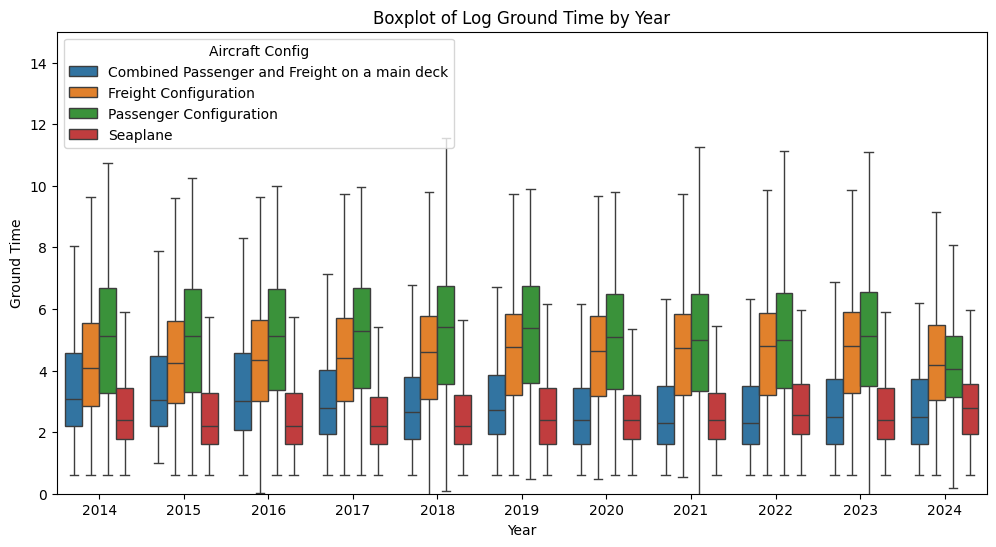

In [59]:
# Create a function to generate weighted grouped data from summary statistics
epsilon = 0.1  # A very small value to adjust min/max

def create_grouped_data_from_summary(df_summary):
    grouped_data = []
    for i, row in df_summary.iterrows():
        year = row.name[0]
        config = row.name[1]

        # Calculate the IQR (Interquartile Range)
        IQR = row['75%'] - row['25%']

        # Adjust the lower and upper whiskers with a small epsilon
        lower_bound = max(row['min'] - epsilon, row['25%'] - 1.5 * IQR)  # Lower whisker
        upper_bound = min(row['max'] + epsilon, row['75%'] + 1.5 * IQR)  # Upper whisker

        # Create weighted data for each summary statistic
        grouped_data.append([year, config, lower_bound, 'lower_bound'])  # Lower whisker
        grouped_data.append([year, config, row['25%'], 'Q1'])            # Q1 (25th percentile)
        grouped_data.append([year, config, row['50%'], 'median'])        # Median (50th percentile)
        grouped_data.append([year, config, row['75%'], 'Q3'])            # Q3 (75th percentile)
        grouped_data.append([year, config, upper_bound, 'upper_bound'])  # Upper whisker

    # Create a DataFrame for the grouped data
    return pd.DataFrame(grouped_data, columns=['YEAR', 'AIRCRAFT_CONFIG_DESC', 'LOG_GROUND_TIME', 'Statistic'])



# Generate the grouped data from the summary statistics
df_boxplot_summary = df_carrier_summary.groupby(['YEAR', 'AIRCRAFT_CONFIG_DESC']).LOG_GROUND_TIME.describe(percentiles=[0.25, 0.5, 0.75])
df_boxplot = create_grouped_data_from_summary(df_boxplot_summary)

# Plot the boxplot using this grouped data
plt.figure(figsize=(12, 6))

# Since we have grouped data, we can use stripplot to simulate a boxplot-like structure
sns.boxplot(x='YEAR', y='LOG_GROUND_TIME', hue='AIRCRAFT_CONFIG_DESC', data=df_boxplot)

# Output to csv file for Streamlit
output_file_path = os.path.join(output_folder, 'boxplot_summary.csv')
df_boxplot.to_csv(output_file_path, index=False)
print(f"Boxplot Summary CSV exported successfully to {output_file_path}!")

# Customize the plot
plt.ylim(0, 15)
plt.title('Boxplot of Log Ground Time by Year')
plt.legend(loc='upper left', title='Aircraft Config')
plt.xlabel('Year')
plt.ylabel('Ground Time')

plt.show()

#### QQ Plot

$n = \frac{Z^2 \cdot p \cdot (1 - p)}{E^2}$

QQ Sample CSV exported successfully to OUTPUT\qq_sample.csv!


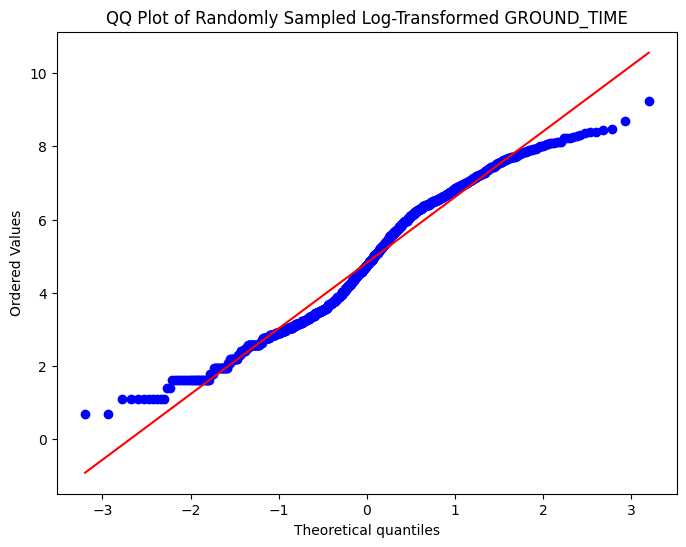

In [60]:
# Random sampling from the original dataset
sample_size = 1000  # Define your sample size
df_sampled = df_carrier_summary.sample(n=sample_size, random_state=0)  # Set a seed for reproducibility

# Ensure that the LOG_GROUND_TIME column exists and has no missing values
log_ground_time_sampled = df_sampled['LOG_GROUND_TIME'].dropna()

# Output to csv file for Streamlit
output_file_path = os.path.join(output_folder, 'qq_sample.csv')
log_ground_time_sampled.to_csv(output_file_path, index=False)
print(f"QQ Sample CSV exported successfully to {output_file_path}!")

# Create a QQ plot using the sampled data
plt.figure(figsize=(8, 6))
stats.probplot(log_ground_time_sampled, dist="norm", plot=plt)
plt.title("QQ Plot of Randomly Sampled Log-Transformed GROUND_TIME")
plt.show()